In [1]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from skimage.transform import resize
import cv2
import torch
import pywt
from torch import nn
from torchsummary import summary
from torch.optim import SGD
import torch.optim as optim
from tensorflow.keras.utils import array_to_img, img_to_array
from torch.autograd import Variable
from scipy import ndimage
import skimage
from skimage import exposure

# Iterate over the files in the specified directory and its subdirectories
for dirname, _, filenames in os.walk('/kaggle/input/pancreas-tcia/images'):
    for filename in filenames:
        # Print the full path of each file
        print(os.path.join(dirname, filename))
filepath="/kaggle/input/pancreas-tcia"

2025-02-11 05:21:13.713986: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-11 05:21:13.714153: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-11 05:21:13.846187: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/pancreas-tcia/images/PANCREAS_0033.npy
/kaggle/input/pancreas-tcia/images/PANCREAS_0031.npy
/kaggle/input/pancreas-tcia/images/PANCREAS_0065.npy
/kaggle/input/pancreas-tcia/images/PANCREAS_0063.npy
/kaggle/input/pancreas-tcia/images/PANCREAS_0046.npy
/kaggle/input/pancreas-tcia/images/PANCREAS_0025.npy
/kaggle/input/pancreas-tcia/images/PANCREAS_0082.npy
/kaggle/input/pancreas-tcia/images/PANCREAS_0080.npy
/kaggle/input/pancreas-tcia/images/PANCREAS_0074.npy
/kaggle/input/pancreas-tcia/images/PANCREAS_0035.npy
/kaggle/input/pancreas-tcia/images/PANCREAS_0041.npy
/kaggle/input/pancreas-tcia/images/PANCREAS_0018.npy
/kaggle/input/pancreas-tcia/images/PANCREAS_0040.npy
/kaggle/input/pancreas-tcia/images/PANCREAS_0032.npy
/kaggle/input/pancreas-tcia/images/PANCREAS_0019.npy
/kaggle/input/pancreas-tcia/images/PANCREAS_0075.npy
/kaggle/input/pancreas-tcia/images/PANCREAS_0058.npy
/kaggle/input/pancreas-tcia/images/PANCREAS_0004.npy
/kaggle/input/pancreas-tcia/images/PANCREAS_00

In [3]:
# Initialize empty lists to store file paths
imageFiles = []  # List to store paths of image files
labelFiles = []  # List to store paths of label files
imageFiles = []
labelFiles = []

# Iterate over the files in the specified directory and its subdirectories
for dirname, _, filenames in os.walk(filepath+'/pancreasct-dataset/labels'):
    for filename in filenames:
        # Check if the file has the '.npy' extension
        if filename.endswith('.npy'):
            # Append the path of the corresponding image file and label file to their respective lists
            imageFiles.append(os.path.join(filepath+'/images', filename))  # Append image file path
            labelFiles.append(os.path.join(dirname, filename))  # Append label file path

# Remove specific items from the lists
#imageFiles.pop(58)
#labelFiles.pop(58)

# Print the modified lists
print(imageFiles)  # Print the list of image file paths
print(labelFiles)  # Print the list of label file paths

['/kaggle/input/pancreas-tcia/images/PANCREAS_0033.npy', '/kaggle/input/pancreas-tcia/images/PANCREAS_0031.npy', '/kaggle/input/pancreas-tcia/images/PANCREAS_0065.npy', '/kaggle/input/pancreas-tcia/images/PANCREAS_0063.npy', '/kaggle/input/pancreas-tcia/images/PANCREAS_0046.npy', '/kaggle/input/pancreas-tcia/images/PANCREAS_0025.npy', '/kaggle/input/pancreas-tcia/images/PANCREAS_0082.npy', '/kaggle/input/pancreas-tcia/images/PANCREAS_0080.npy', '/kaggle/input/pancreas-tcia/images/PANCREAS_0074.npy', '/kaggle/input/pancreas-tcia/images/PANCREAS_0035.npy', '/kaggle/input/pancreas-tcia/images/PANCREAS_0041.npy', '/kaggle/input/pancreas-tcia/images/PANCREAS_0018.npy', '/kaggle/input/pancreas-tcia/images/PANCREAS_0040.npy', '/kaggle/input/pancreas-tcia/images/PANCREAS_0032.npy', '/kaggle/input/pancreas-tcia/images/PANCREAS_0019.npy', '/kaggle/input/pancreas-tcia/images/PANCREAS_0075.npy', '/kaggle/input/pancreas-tcia/images/PANCREAS_0058.npy', '/kaggle/input/pancreas-tcia/images/PANCREAS_00

In [4]:
# Define the depth of the image in pixels
im_depth = 162

# Define the height of the image in pixels
im_height = 300

# Define the width of the image in pixels
im_width = 300

In [5]:
# Declaring an empty NumPy array to store all slices for training images
trainImages = 82-8-8  # Number of training images

# Calculating the number of testing images
testImages = 8

# Calculating the number of validation images
valImages = 8

In [6]:
def remove_background1(img):
    """
    Function to remove background from an image tensor based on a threshold.

    Args:
    - img: Input image tensor

    Returns:
    - Tensor with background removed
    """

    # Flatten the tensor to a 1D array
    #img = torch.Tensor(img)  # Convert input to a PyTorch tensor
    #tensor_flattened = img.flatten()  # Flatten the tensor to 1D array
    img1=img.flatten()
    # Calculate the threshold based on the mean and standard deviation of pixel values
    threshold = (np.mean(img1) + (np.std(img1)*0.0))
    threshold1 = (np.mean(img1) + (np.std(img1)*1.5))

    # Apply thresholding to remove background
    if threshold>=0:
        return (((threshold) < img) * ((threshold1) >= img) * (img))+((threshold1 < img)*threshold1)
    else:
        return (((threshold) < img) * ((threshold1) >= img) * (img - threshold))+((threshold1 < img)*(threshold1-threshold))

In [7]:
import torch.nn.functional as F
import cv2

def conv3D(matrix, kernel):
    # Check if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Move data to GPU
    matrix = torch.tensor(np.reshape(matrix, (1,1, 162, 300, 300)), dtype=torch.float32).to(device)
    kernel = kernel.to(device)
    
    # Perform 3D convolution on GPU
    output = F.conv3d(matrix, kernel, padding='same')
    
    # Normalize output
    #output = ((output - output.min())*2 / (output.max() - output.min()))-1

    # Move result back to CPU before converting to NumPy
    return output.cpu().numpy()

def conv3D_unet(matrix, kernel):
    # Check if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Move data to GPU
    matrix = torch.tensor(np.reshape(matrix, (1,1, 128,128,200)), dtype=torch.float32).to(device)
    kernel = kernel.to(device)
    
    # Perform 3D convolution on GPU
    output = F.conv3d(matrix, kernel, padding='same')
    
    # Normalize output
    #output = ((output - output.min())*2 / (output.max() - output.min()))-1

    # Move result back to CPU before converting to NumPy
    return output.cpu().numpy()


kernel2 = torch.tensor((
    np.reshape(np.array(
    (((0,0,0),(0,-1,0),(0,0,0))
    ,((0,-1,0),(-1,7,-1),(0,-1,0))
    ,((0,0,0),(0,-1,0),(0,0,0)))
    )
    ,(1,1,3,3,3))
), dtype=torch.float32)

kernel = torch.tensor((
    np.reshape(np.array(
    (((1,2,1),(4,8,4),(1,2,1))
    ,((2,1,2),(8,16,8),(2,1,2))
    ,((1,2,1),(4,8,4),(1,2,1)))
    )
    ,(1,1,3,3,3))
), dtype=torch.float32)


In [8]:
def process_image(imageFile):
    """
    Process an image file.

    Args:
    - imageFile: Path to the image file

    Returns:
    - Processed image tensor
    """

    # Load the image file using NumPy
    img = np.load(imageFile)
    #img = np.flip(img, axis=1)
    Z_Front=65
    #if(i==68):
    #    Z_Front=180
    if(img.shape[2]-162<Z_Front):
        Z_Front=img.shape[2]-162
    Z_Back=Z_Front+162
    

    # Crop the image based on specified dimensions
    image = img[150:450, 150:450, Z_Front:Z_Back]

    # Transpose the image array
    img = image.transpose()
    # Clipping
    #img=resample_image(img)
    img= np.clip(img, -100, 300)
    # Normalization
    img = (img + 100) / 400
    img = ((img - img.min())*2 / (img.max() - img.min()))-1

    img=skimage.exposure.equalize_hist(img)
    img=conv3D(img, kernel2)
    img = ((img - img.min()) / (img.max() - img.min()))
    img=np.resize(img, (im_depth, im_height, im_width))
    return img

In [9]:
def process_image_unet(imageFile,frontz,backz, frontx,backx, fronty,backy):
    """
    Process an image file.

    Args:
    - imageFile: Path to the image file

    Returns:
    - Processed image tensor
    """

    # Load the image file using NumPy
    img = np.load(imageFile)
    #img = np.flip(img, axis=1)
    Z_Front=65
    #if(i==68):
    #    Z_Front=180
    if(img.shape[2]-162<Z_Front):
        Z_Front=img.shape[2]-162
    Z_Back=Z_Front+162
    

    # Crop the image based on specified dimensions
    image = img[150:450, 150:450, Z_Front:Z_Back]

    # Transpose the image array
    img = image.transpose()
    img=img[frontz:backz, frontx:backx, fronty:backy]
    # Clipping
    #img=resample_image(img)
    img= np.clip(img, -100, 300)
    # Normalization
    img = (img + 100) / 400
    img = ((img - img.min())*2 / (img.max() - img.min()))-1

    img=skimage.exposure.equalize_hist(img)
    img=conv3D_unet(img, kernel2)
    img = ((img - img.min()) / (img.max() - img.min()))
    img=np.resize(img, (im_depth1, im_height1, im_width1))
    return img

def process_image(imageFile):
    """
    Process an image file.

    Args:
    - imageFile: Path to the image file

    Returns:
    - Processed image tensor
    """

    # Load the image file using NumPy
    img = np.load(imageFile)

    Z_Front=34
    Z_Back=196
    if img.shape[2]<Z_Back:
        Z_Front=Z_Front-(Z_Back-img.shape[2])
        Z_Back=img.shape[2]

    # Crop the image based on specified dimensions
    image = img[150:450, 150:450, Z_Front:Z_Back]

    # Transpose the image array
    img = image.transpose()

    # Convert the image array to a PyTorch tensor
    img=np.resize(img, (1, im_depth, im_height, im_width))
    img,val=normalize_image(img)
    
    # Apply CLAHE to the 3D image
    clahe = skimage.exposure.equalize_adapthist
    img = clahe(img, clip_limit=0.01)
    img2=img
    img=remove_background1(img)

    img=(img*val).numpy()
    img=np.resize(img, (1,1, im_depth, im_height, im_width))
    img2=np.resize(img2, (1,1, im_depth, im_height, im_width))
    return torch.Tensor(img),torch.Tensor(img2)

In [10]:
# Define the batch size for processing data in mini-batches
BATCH_SIZE = 1

In [11]:
# Load pre-trained models from saved checkpoints
modelx = torch.load('/kaggle/input/rcnn_set_confer/pytorch/default/1/checkpoint_x.pt')
modely = torch.load('/kaggle/input/rcnn_set_confer/pytorch/default/1/checkpoint_y.pt')
modelz = torch.load('/kaggle/input/rcnn_set_confer/pytorch/default/1/checkpoint_z.pt')

/opt/conda/lib/python3.10/site-packages/torch/serialization.py:995: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


In [12]:
# Move the pre-trained models to the GPU for computation
modelx.cuda()
modely.cuda()
modelz.cuda()

RecursiveScriptModule(
  original_name=RCNN
  (bn): RecursiveScriptModule(original_name=BatchNorm3d)
  (a_block1): RecursiveScriptModule(
    original_name=Conv3DBlockn
    (conv1): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(original_name=Conv3d)
      (1): RecursiveScriptModule(original_name=BatchNorm3d)
      (2): RecursiveScriptModule(original_name=ReLU)
      (3): RecursiveScriptModule(original_name=Conv3d)
      (4): RecursiveScriptModule(original_name=BatchNorm3d)
      (5): RecursiveScriptModule(original_name=ReLU)
    )
  )
  (att_block1): RecursiveScriptModule(
    original_name=Attention
    (block1): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(original_name=Conv3d)
      (1): RecursiveScriptModule(original_name=BatchNorm3d)
      (2): RecursiveScriptModule(original_name=ReLU)
    )
    (block2): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(original

In [13]:
# Initialize variables x, y, and z to zero
x = 0
y = 0
z = 0

In [14]:
def process_label(labelFile):
    img = np.load(labelFile)
    #print(img.shape)
    Z_Front=65
    if(img.shape[2]-162<Z_Front):
        Z_Front=img.shape[2]-162
    Z_Back=Z_Front+162
    img= np.flip(img, axis=1)
    # Crop the image based on specified dimensions
    image = img[150:450, 150:450, Z_Front:Z_Back]

    # Transpose the image array
    image = image.transpose()
    #print('label shape',image.shape)
    image=image>0
    # Convert the image array to a PyTorch tensor
    img=np.resize(image, (1, 1, im_depth, im_height, im_width))
    
    img= np.array(img, dtype=np.int8)
    return img

In [15]:
def resize_mid(x, val, val2):
    array1 = np.arange(0, val2)
    x = set(x.flatten()*array1)
    x = np.array(list(x))
    print(len(x))
    median_val=np.median(x)
    front=int(median_val-(val/2))
    back=front+val
    
    # Check if back index exceeds the desired shape, adjust front and back indices accordingly
    if back > (val2):
        front = front - (back - (val2))
        back = val2
    # Check if front index is less than zero, adjust front and back indices accordingly
    elif front < 0:
        back = back - front
        front = 0
    
    return front, back

In [16]:
def cropped_img(x, val, val2):
    array1 = np.arange(0, val2)
    x = set(x.flatten())
    x = np.array(list(x))
    length=len(x)
    median_val=np.median(x)
    front=int(median_val-(length/2))
    back=front+length
    
    # Check if back index exceeds the desired shape, adjust front and back indices accordingly
    if back > (val2):
        front = front - (back - (val2))
        back = val2
    # Check if front index is less than zero, adjust front and back indices accordingly
    elif front < 0:
        back = back - front
        front = 0
    
    length2 = (val-back+front)/2
    
    
    return length2, front, back

In [17]:
def get_array_output(yhatz,length,length2):
    frontz, backz = resize_mid(yhatz, length, length2)
    output1=np.zeros(length2)
    output2=np.ones(backz-frontz)
    #print("  z:", backz + 1, frontz)
    output1[frontz:backz]=output2
    output1=np.resize(output1,(1,length2))
    #output1 = torch.Tensor(output1)
    #output1 = Variable(output1, requires_grad=True).type(dtype)
    return output1

In [18]:
def clean_array(x,val,val2):
    # Initialize variables to store the indices of the predicted boundary
    #x=x.cpu().detach().numpy()
    #print('clean array',x.shape)
    front = 0
    back = x.shape[1] - 1
    
    # Find the front boundary of the predicted array
    while x[0][front] == 0:
        front = front + 1
        
    # Find the back boundary of the predicted array
    while x[0][back] == 0:
        back = back - 1
    '''back+=20
    front+=20
    if(front<0)
    {
        back-=front
        front=0
    }
    elif(back>=val2)
    {
        front-=back-val2+1
        back=val2-1
    }'''
    l=back-front
    if((val-l)<0):
        l=l-val
        left=0
    else:
        left=((val-l)/2)
        l=0
    # Return the indices of the predicted boundary
    return int(left),int(front+(l/2)), int(back-l+(l/2))

In [19]:
# Define the dimensions of an image volume
im_depth1 = 128   # Depth of the image volume
im_height1 = 128  # Height of the image volume
im_width1 = 200  # Width of the image volume

In [20]:
# Declaring an empty NumPy array to store all slices for training images

# Initializing an empty array with dimensions (trainImages, 1, im_height, im_width, im_depth) filled with zeros and of integer data type
X_train = np.zeros((trainImages, 1, im_depth1, im_height1, im_width1), dtype=np.float32)
print(X_train.shape)  # Print the shape of the array

# Initializing an empty array for training labels with dimensions (trainImages, 1, im_height, im_width, im_depth) filled with zeros and of float32 data type
y_train = np.zeros((trainImages, 1, im_depth1, im_height1, im_width1), dtype=np.float32)
print(y_train.shape)  # Print the shape of the array

# Declaring an empty NumPy array to store all slices for testing images
X_test = np.zeros((testImages, 1, im_depth1, im_height1, im_width1), dtype=np.float32)
print(X_test.shape)  # Print the shape of the array

# Initializing an empty array for testing labels with dimensions (testImages, 1, im_height, im_width, im_depth) filled with zeros and of float32 data type
y_test = np.zeros((testImages, 1, im_depth1, im_height1, im_width1), dtype=np.float32)
print(y_test.shape)  # Print the shape of the array

# Declaring an empty NumPy array to store all slices for validation images
X_val = np.zeros((valImages, 1, im_depth1, im_height1, im_width1), dtype=np.float32)
print(X_val.shape)  # Print the shape of the array

# Initializing an empty array for validation labels with dimensions (valImages, 1, im_height, im_width, im_depth) filled with zeros and of float32 data type
y_val = np.zeros((valImages, 1, im_depth1, im_height1, im_width1), dtype=np.float32)
print(y_val.shape)  # Print the shape of the array

(66, 1, 128, 128, 200)
(66, 1, 128, 128, 200)
(8, 1, 128, 128, 200)
(8, 1, 128, 128, 200)
(8, 1, 128, 128, 200)
(8, 1, 128, 128, 200)


In [21]:
# Define the data type for tensors to be stored on the GPU
dtype = torch.cuda.FloatTensor

In [22]:
li=[]

In [23]:
import scipy.ndimage
import torch.nn.functional as F
def sharpening(img):
    # Define a 3D sharpening kernel
    kernel = np.array([[[ 0,  0,  0],
                        [ 0, -1,  0],
                        [ 0,  0,  0]],

                       [[ 0, -1,  0],
                        [-1,  6, -1],
                        [ 0, -1,  0]],

                       [[ 0,  0,  0],
                        [ 0, -1,  0],
                        [ 0,  0,  0]]])
    kernel_tensor = torch.tensor(kernel, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    sharpened_image = F.conv3d(torch.Tensor(img), kernel_tensor, padding=1)
    return img*(np.array(sharpened_image)<0.8)

In [24]:
clahe = skimage.exposure.equalize_adapthist

In [25]:
# Function to perform DSIHE
def dualistic_sub_image_histogram_equalization(image):
    # Flatten the image to 1D
    flat_image = image.flatten()
    # Calculate the histogram
    hist, bins = np.histogram(flat_image, bins=256, range=[0, 256])
    # Calculate the cumulative distribution function (CDF)
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max() / cdf.max()
    
    # Find the median of the CDF
    median = np.median(cdf)
    
    # Split the histogram into two sub-histograms
    lower_hist = hist[cdf <= median]
    upper_hist = hist[cdf > median]
    
    # Equalize each sub-histogram
    lower_cdf = lower_hist.cumsum()
    upper_cdf = upper_hist.cumsum()
    
    lower_cdf_normalized = lower_cdf * lower_hist.max() / lower_cdf.max()
    upper_cdf_normalized = upper_cdf * upper_hist.max() / upper_cdf.max()
    
    # Map the original image pixels to the equalized histograms
    equalized_image = np.interp(flat_image, bins[:-1], np.hstack((lower_cdf_normalized, upper_cdf_normalized)))
    
    # Reshape the equalized image back to 3D
    equalized_image = equalized_image.reshape(image.shape)
    
    return equalized_image


def compute_histogram(image):
    # Flatten the 3D image to 1D array and compute the histogram
    hist, bins = np.histogram(image.flatten(), bins=256, range=[0,256])
    return hist

def equalize_histogram(image):
    # Apply OpenCV's equalizeHist to each slice of the 3D image
    eq_image = np.zeros_like(image)
    for i in range(image.shape[0]):  # Iterate through the depth
        eq_image[i] = cv2.equalizeHist(image[i].astype(np.uint8))
    return eq_image

def dualistic_subimage_histogram_equalization(image):
    # Compute histogram of the image
    hist = compute_histogram(image)
    
    # Find the median intensity value
    cdf = hist.cumsum()  # Cumulative distribution function
    total_pixels = cdf[-1]
    median_intensity = np.searchsorted(cdf, total_pixels // 2)
    
    # Split the image based on median intensity
    low_intensity_mask = image <= median_intensity
    high_intensity_mask = image > median_intensity
    
    # Separate the two sub-images
    low_intensity_image = np.copy(image)
    high_intensity_image = np.copy(image)
    
    # Apply mask
    low_intensity_image[~low_intensity_mask] = 0
    high_intensity_image[~high_intensity_mask] = 0
    
    # Apply histogram equalization to both sub-images
    eq_low_intensity_image = equalize_histogram(low_intensity_image)
    eq_high_intensity_image = equalize_histogram(high_intensity_image)
    
    # Combine the two sub-images back
    final_image = np.where(low_intensity_mask, eq_low_intensity_image, eq_high_intensity_image)
    
    return final_image

In [26]:
structuring_element = np.ones((3, 3, 3))

In [27]:
def resize_mid(x, val, val2):
    array1 = np.arange(0, val2)
    x=np.array(x*array1)
    x = set(x.flatten())
    x = np.array(list(x))
    median_val=np.median(x)
    front=int(median_val-(val/2))
    back=front+val
    # Check if back index exceeds the desired shape, adjust front and back indices accordingly
    if back > (val2):
        front = front - (back - (val2))
        back = val2
    # Check if front index is less than zero, adjust front and back indices accordingly
    elif front < 0:
        back = back - front
        front = 0
    return front, back

In [28]:
loss_checkpoint = 1000
count = 0
loss = 0
val_loss = 0

# Evaluate the model
for i in range(0, trainImages):
    # Process input and label images
    img1=process_image(imageFiles[i])
    X=torch.Tensor(np.resize(img1, (1, im_depth, im_height, im_width)))
    Y = process_label(labelFiles[i])
    Y=Y>0
    y_img = Y
    print(i+1, "\n")
    
    # Convert inputs and targets to PyTorch variables and move them to GPU
    inputs = Variable(X, requires_grad=True).type(dtype)
    #targets = Variable(Y).type(dtype)
    
    # Predict along z-axis
    yhatz = modelz(inputs.unsqueeze(0))
    yhatz = (yhatz > 0.5) * 1.0
    #lz,frontz, backz=clean_array(yhatz.cpu().detach().numpy(),im_depth1,im_depth)
    lz=0
    frontz, backz=resize_mid(yhatz.cpu().detach().numpy(),im_depth1,im_depth)
    #cfrontz, frontz, backz = cropped_img(yhatz.cpu().detach().numpy(),im_depth1,im_depth)
    #frontz, backz = clean_array(yhatz)
    print("  z:", backz - frontz)
    
    # Predict along x-axis
    yhatx = modelx(inputs.unsqueeze(0))
    yhatx = (yhatx > 0.5) * 1.0
    #lx,frontx, backx=clean_array(yhatx.cpu().detach().numpy(),im_height1,im_height)
    lx=0
    frontx, backx=resize_mid(yhatx.cpu().detach().numpy(),im_height1,im_height)
    #cfrontx, frontx, backx = cropped_img(yhatx.cpu().detach().numpy(),im_height1,im_height)
    #frontx, backx = clean_array(yhatx)
    print("   x:", backx - frontx)
    
    # Predict along y-axis
    yhaty = modely(inputs.unsqueeze(0))
    yhaty = (yhaty > 0.5) * 1.0
    #ly,fronty, backy=clean_array(yhaty.cpu().detach().numpy(),im_width1,im_width)
    ly=0
    fronty, backy=resize_mid(yhaty.cpu().detach().numpy(),im_width1,im_width)
    #cfronty, fronty, backy = cropped_img(yhaty.cpu().detach().numpy(),im_width1,im_width)
    #fronty, backy = clean_array(yhaty)
    print(" y:", backy - fronty)
    
    #print(img.shape)
    # Remove background and reconstruct using wavelet transform    
    
    img1=process_image_unet(imageFiles[i],frontz,backz, frontx,backx, fronty,backy)
    y_img=y_img[:,:,frontz:backz, frontx:backx, fronty:backy][0]
    
    #print(np.min(img))
    # Resize and store input images
    X_train[i] = np.resize(img1, (1, im_depth1, im_height1, im_width1))
    # Resize and store label images
    y_train[i] = np.resize(y_img, (1, im_depth1, im_height1, im_width1))
    '''
    print(Y.shape)
    
    print(img.shape)
    print(y_img.shape)
    print(Y.shape)'''
    print("   x:", backz, "  ", frontz, "   x:", backx, "  ", frontx, "   y:", backy, "  ", fronty)
    print(sum(sum(sum(sum(y_img)))),
          "  ", sum(sum(sum(sum(sum(Y))))), "   Pancreas percentage:", sum(sum(sum(sum(y_img)))) / sum(sum(sum(sum(sum(Y))))))

1 

  z: 128
   x: 128
 y: 200
   x: 153    25    x: 205    77    y: 234    34
107927    109014    Pancreas percentage: 0.9900288036398994
2 

  z: 128
   x: 128
 y: 200
   x: 146    18    x: 143    15    y: 232    32
148476    149457    Pancreas percentage: 0.9934362391858528
3 

  z: 128
   x: 128
 y: 200
   x: 130    2    x: 151    23    y: 237    37
66205    66205    Pancreas percentage: 1.0
4 

  z: 128
   x: 128
 y: 200
   x: 143    15    x: 151    23    y: 234    34
110274    110274    Pancreas percentage: 1.0
5 

  z: 128
   x: 128
 y: 200
   x: 134    6    x: 158    30    y: 242    42
97744    103062    Pancreas percentage: 0.9483999922376821
6 

  z: 128
   x: 128
 y: 200
   x: 145    17    x: 132    4    y: 242    42
118723    119173    Pancreas percentage: 0.996223976907521
7 

  z: 128
   x: 128
 y: 200
   x: 132    4    x: 128    0    y: 246    46
72596    72596    Pancreas percentage: 1.0
8 

  z: 128
   x: 128
 y: 200
   x: 147    19    x: 171    43    y: 234    34
8165

In [29]:
np.max(X_train[0])

1.0

<Figure size 8000x5000 with 0 Axes>

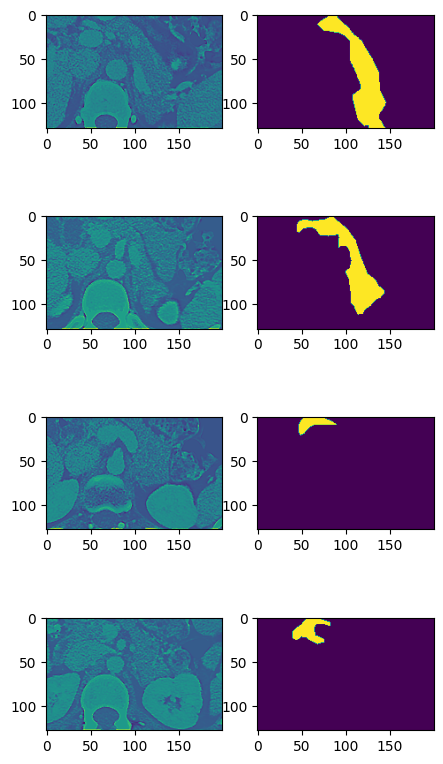

In [30]:
slice_no = [50, 60, 70, 80]
pos=0


# Create a figure and subplots
plt.figure(figsize=(80, 50))
f, axarr = plt.subplots(len(slice_no), 2, figsize=(5, 10))

# Iterate over each slice number
for i in range(len(slice_no)):
    # Display the input image in the left subplot
    axarr[i][0].imshow(np.resize(X_train[pos][0][slice_no[i]], (X_train.shape[3], X_train.shape[4], 1)))
    # Display the corresponding label image in the right subplot
    axarr[i][1].imshow(np.resize(y_train[pos][0][slice_no[i]], (X_train.shape[3], X_train.shape[4], 1)))

In [31]:
np.min(X_train[0])

0.0

<Figure size 8000x5000 with 0 Axes>

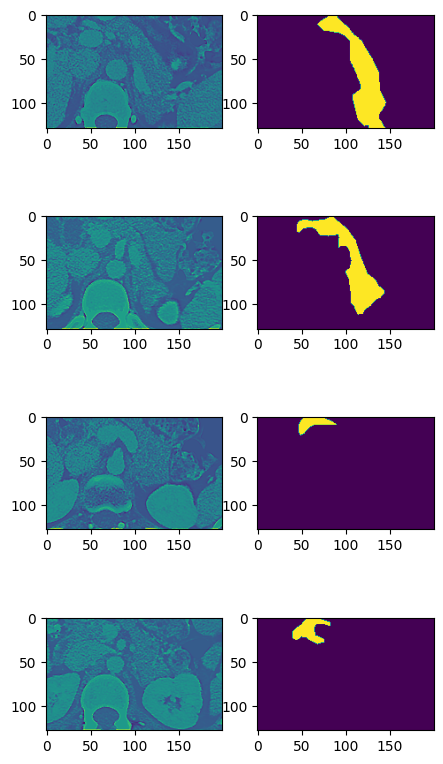

In [32]:
slice_no = [50, 60, 70, 80]

# Create a figure and subplots
plt.figure(figsize=(80, 50))
f, axarr = plt.subplots(len(slice_no), 2, figsize=(5, 10))

# Iterate over each slice number
for i in range(len(slice_no)):
    # Display the input image in the left subplot
    axarr[i][0].imshow(np.resize(X_train[0][0][slice_no[i]], (X_train.shape[3], X_train.shape[4], 1)))
    # Display the corresponding label image in the right subplot
    axarr[i][1].imshow(np.resize(y_train[0][0][slice_no[i]], (y_train.shape[3], y_train.shape[4], 1)))

In [33]:
# Evaluate the model
for i in range(trainImages, trainImages + testImages):
    # Process input and label images
    img1=process_image(imageFiles[i])
    X=torch.Tensor(np.resize(img1, (1, im_depth, im_height, im_width)))
    Y = process_label(labelFiles[i])
    Y=Y>0
    y_img = Y
    print(i+1, "\n")
    
    # Convert inputs and targets to PyTorch variables and move them to GPU
    inputs = Variable(X, requires_grad=True).type(dtype)
    #targets = Variable(Y).type(dtype)
    
    # Predict along z-axis
    yhatz = modelz(inputs.unsqueeze(0))
    yhatz = (yhatz > 0.5) * 1.0
    #lz,frontz, backz=clean_array(yhatz.cpu().detach().numpy(),im_depth1,im_depth)
    lz=0
    frontz, backz=resize_mid(yhatz.cpu().detach().numpy(),im_depth1,im_depth)
    #cfrontz, frontz, backz = cropped_img(yhatz.cpu().detach().numpy(),im_depth1,im_depth)
    #frontz, backz = clean_array(yhatz)
    print("  z:", backz - frontz)
    
    # Predict along x-axis
    yhatx = modelx(inputs.unsqueeze(0))
    yhatx = (yhatx > 0.5) * 1.0
    #lx,frontx, backx=clean_array(yhatx.cpu().detach().numpy(),im_height1,im_height)
    lx=0
    frontx, backx=resize_mid(yhatx.cpu().detach().numpy(),im_height1,im_height)
    #cfrontx, frontx, backx = cropped_img(yhatx.cpu().detach().numpy(),im_height1,im_height)
    #frontx, backx = clean_array(yhatx)
    print("   x:", backx - frontx)
    
    # Predict along y-axis
    yhaty = modely(inputs.unsqueeze(0))
    yhaty = (yhaty > 0.5) * 1.0
    #ly,fronty, backy=clean_array(yhaty.cpu().detach().numpy(),im_width1,im_width)
    ly=0
    fronty, backy=resize_mid(yhaty.cpu().detach().numpy(),im_width1,im_width)
    #cfronty, fronty, backy = cropped_img(yhaty.cpu().detach().numpy(),im_width1,im_width)
    #fronty, backy = clean_array(yhaty)
    print(" y:", backy - fronty)
    
    img1=process_image_unet(imageFiles[i],frontz,backz, frontx,backx, fronty,backy)
    y_img=y_img[:,:,frontz:backz, frontx:backx, fronty:backy][0]
    
    # Resize and store input images
    X_test[i-trainImages] = np.resize(img1, (1, im_depth1, im_height1, im_width1))
    # Resize and store label images
    y_test[i-trainImages] = np.resize(y_img, (1, im_depth1, im_height1, im_width1))
    '''
    print(Y.shape)
    
    print(img.shape)
    print(y_img.shape)
    print(Y.shape)'''
    print("   x:", backz, "  ", frontz, "   x:", backx, "  ", frontx, "   y:", backy, "  ", fronty)
    print(sum(sum(sum(sum(y_img)))),
          "  ", sum(sum(sum(sum(sum(Y))))), "   Pancreas percentage:", sum(sum(sum(sum(y_img)))) / sum(sum(sum(sum(sum(Y))))))
    

67 

  z: 128
   x: 128
 y: 200
   x: 137    9    x: 152    24    y: 236    36
63743    64789    Pancreas percentage: 0.9838552840760005
68 

  z: 128
   x: 128
 y: 200
   x: 138    10    x: 146    18    y: 238    38
157278    157370    Pancreas percentage: 0.999415390481032
69 

  z: 128
   x: 128
 y: 200
   x: 144    16    x: 146    18    y: 242    42
13490    31757    Pancreas percentage: 0.4247882356645779
70 

  z: 128
   x: 128
 y: 200
   x: 136    8    x: 148    20    y: 238    38
100044    100044    Pancreas percentage: 1.0
71 

  z: 128
   x: 128
 y: 200
   x: 141    13    x: 151    23    y: 244    44
92538    123416    Pancreas percentage: 0.7498055357490114
72 

  z: 128
   x: 128
 y: 200
   x: 146    18    x: 153    25    y: 245    45
155807    156716    Pancreas percentage: 0.9941996988182444
73 

  z: 128
   x: 128
 y: 200
   x: 134    6    x: 150    22    y: 238    38
88183    88183    Pancreas percentage: 1.0
74 

  z: 128
   x: 128
 y: 200
   x: 132    4    x: 148    2

In [34]:
# Evaluate the model
for i in range(trainImages + testImages, trainImages + testImages + valImages):
    # Process input and label images
    img1=process_image(imageFiles[i])
    X=torch.Tensor(np.resize(img1, (1, im_depth, im_height, im_width)))
    Y = process_label(labelFiles[i])
    Y=Y>0
    y_img = Y
    print(i+1, "\n")
    
    # Convert inputs and targets to PyTorch variables and move them to GPU
    inputs = Variable(X, requires_grad=True).type(dtype)
    #targets = Variable(Y).type(dtype)
    
    # Predict along z-axis
    yhatz = modelz(inputs.unsqueeze(0))
    yhatz = (yhatz > 0.5) * 1.0
    #lz,frontz, backz=clean_array(yhatz.cpu().detach().numpy(),im_depth1,im_depth)
    lz=0
    frontz, backz=resize_mid(yhatz.cpu().detach().numpy(),im_depth1,im_depth)
    #cfrontz, frontz, backz = cropped_img(yhatz.cpu().detach().numpy(),im_depth1,im_depth)
    #frontz, backz = clean_array(yhatz)
    print("  z:", backz - frontz)
    
    # Predict along x-axis
    yhatx = modelx(inputs.unsqueeze(0))
    yhatx = (yhatx > 0.5) * 1.0
    #lx,frontx, backx=clean_array(yhatx.cpu().detach().numpy(),im_height1,im_height)
    lx=0
    frontx, backx=resize_mid(yhatx.cpu().detach().numpy(),im_height1,im_height)
    #cfrontx, frontx, backx = cropped_img(yhatx.cpu().detach().numpy(),im_height1,im_height)
    #frontx, backx = clean_array(yhatx)
    print("   x:", backx - frontx)
    
    # Predict along y-axis
    yhaty = modely(inputs.unsqueeze(0))
    yhaty = (yhaty > 0.5) * 1.0
    #ly,fronty, backy=clean_array(yhaty.cpu().detach().numpy(),im_width1,im_width)
    ly=0
    fronty, backy=resize_mid(yhaty.cpu().detach().numpy(),im_width1,im_width)
    #cfronty, fronty, backy = cropped_img(yhaty.cpu().detach().numpy(),im_width1,im_width)
    #fronty, backy = clean_array(yhaty)
    print(" y:", backy - fronty)
    
    img1=process_image_unet(imageFiles[i],frontz,backz, frontx,backx, fronty,backy)
    y_img=y_img[:,:,frontz:backz, frontx:backx, fronty:backy][0]
    
    # Resize and store input images
    X_val[i-trainImages-testImages] = np.resize(img1, (1, im_depth1, im_height1, im_width1))
    # Resize and store label images
    y_val[i-trainImages-testImages] = np.resize(y_img, (1, im_depth1, im_height1, im_width1))
    '''
    print(Y.shape)
    
    print(img.shape)
    print(y_img.shape)
    print(Y.shape)'''
    print("   x:", backz, "  ", frontz, "   x:", backx, "  ", frontx, "   y:", backy, "  ", fronty)
    print(sum(sum(sum(sum(y_img)))),
          "  ", sum(sum(sum(sum(sum(Y))))), "   Pancreas percentage:", sum(sum(sum(sum(y_img)))) / sum(sum(sum(sum(sum(Y))))))
    

75 

  z: 128
   x: 128
 y: 200
   x: 139    11    x: 152    24    y: 237    37
69796    80604    Pancreas percentage: 0.8659123616693961
76 

  z: 128
   x: 128
 y: 200
   x: 137    9    x: 145    17    y: 241    41
149659    149659    Pancreas percentage: 1.0
77 

  z: 128
   x: 128
 y: 200
   x: 138    10    x: 153    25    y: 241    41
78869    79155    Pancreas percentage: 0.9963868359547723
78 

  z: 128
   x: 128
 y: 200
   x: 131    3    x: 150    22    y: 237    37
69120    69120    Pancreas percentage: 1.0
79 

  z: 128
   x: 128
 y: 200
   x: 137    9    x: 153    25    y: 240    40
106612    112454    Pancreas percentage: 0.9480498692798833
80 

  z: 128
   x: 128
 y: 200
   x: 135    7    x: 152    24    y: 240    40
98298    101061    Pancreas percentage: 0.9726600765874076
81 

  z: 128
   x: 128
 y: 200
   x: 131    3    x: 150    22    y: 237    37
119885    119997    Pancreas percentage: 0.99906664333275
82 

  z: 128
   x: 128
 y: 200
   x: 134    6    x: 148    20  

<Figure size 10000x6000 with 0 Axes>

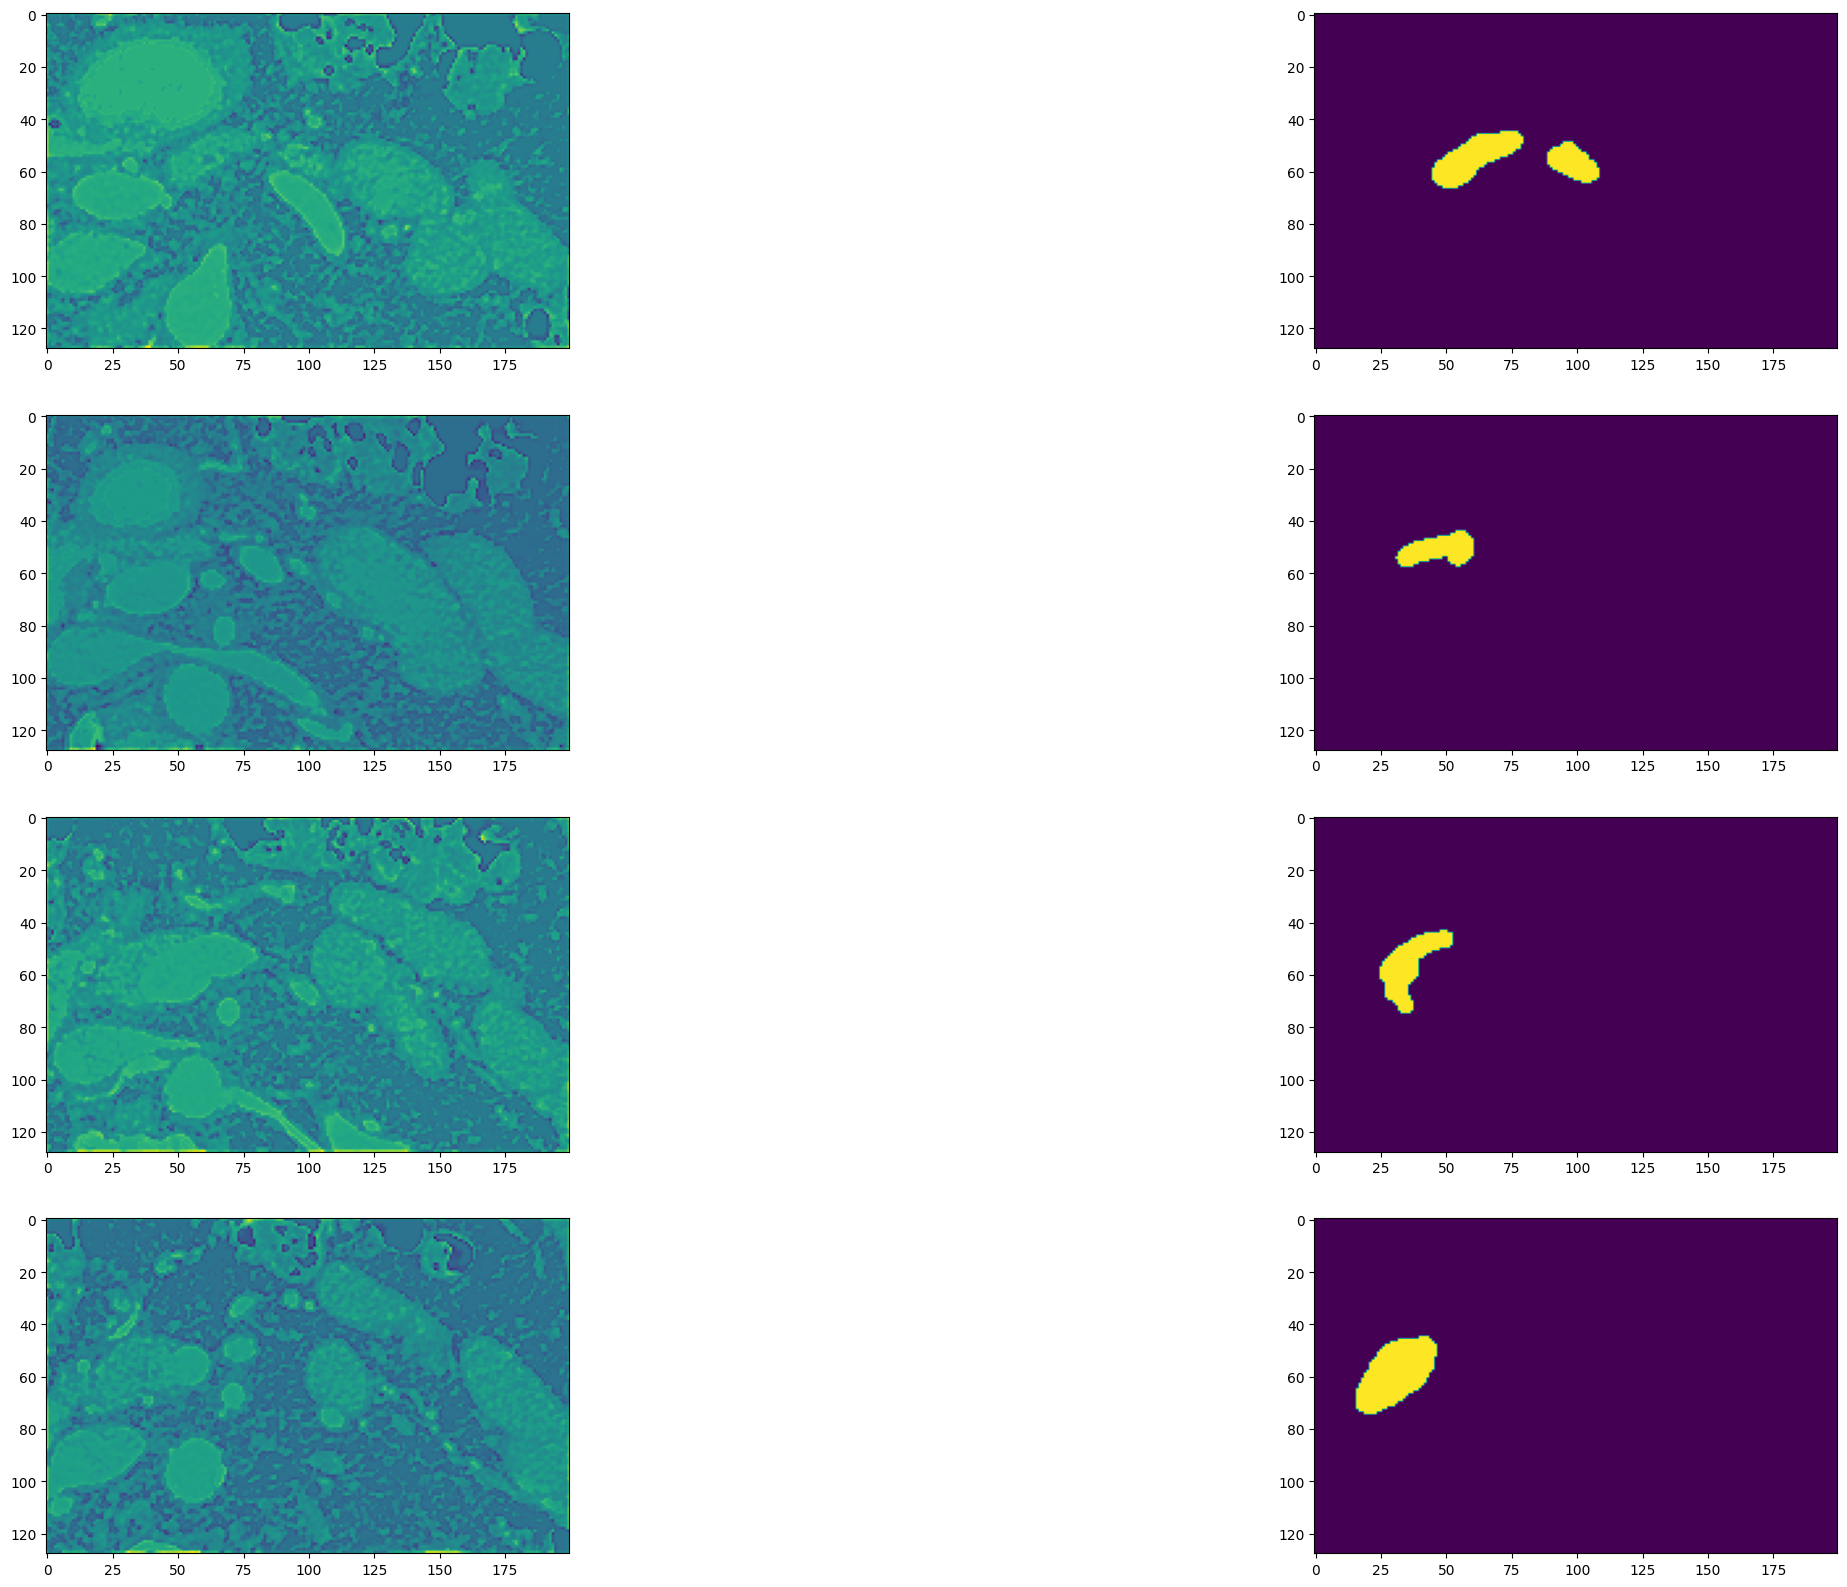

In [35]:
slice_no = [50, 60, 70, 80]
val=2
# Create a figure and subplots
plt.figure(figsize=(100, 60))
f, axarr = plt.subplots(len(slice_no), 2, figsize=(30, 20))

# Iterate over each slice number
for i in range(len(slice_no)):
    # Display the input image in the left subplot
    axarr[i][0].imshow(np.resize(X_val[val][0][slice_no[i]], (X_val.shape[3], X_val.shape[4], 1)))
    # Display the corresponding label image in the right subplot
    axarr[i][1].imshow(np.resize(y_val[val][0][slice_no[i]], (y_val.shape[3], y_val.shape[4], 1)))

<Figure size 10000x6000 with 0 Axes>

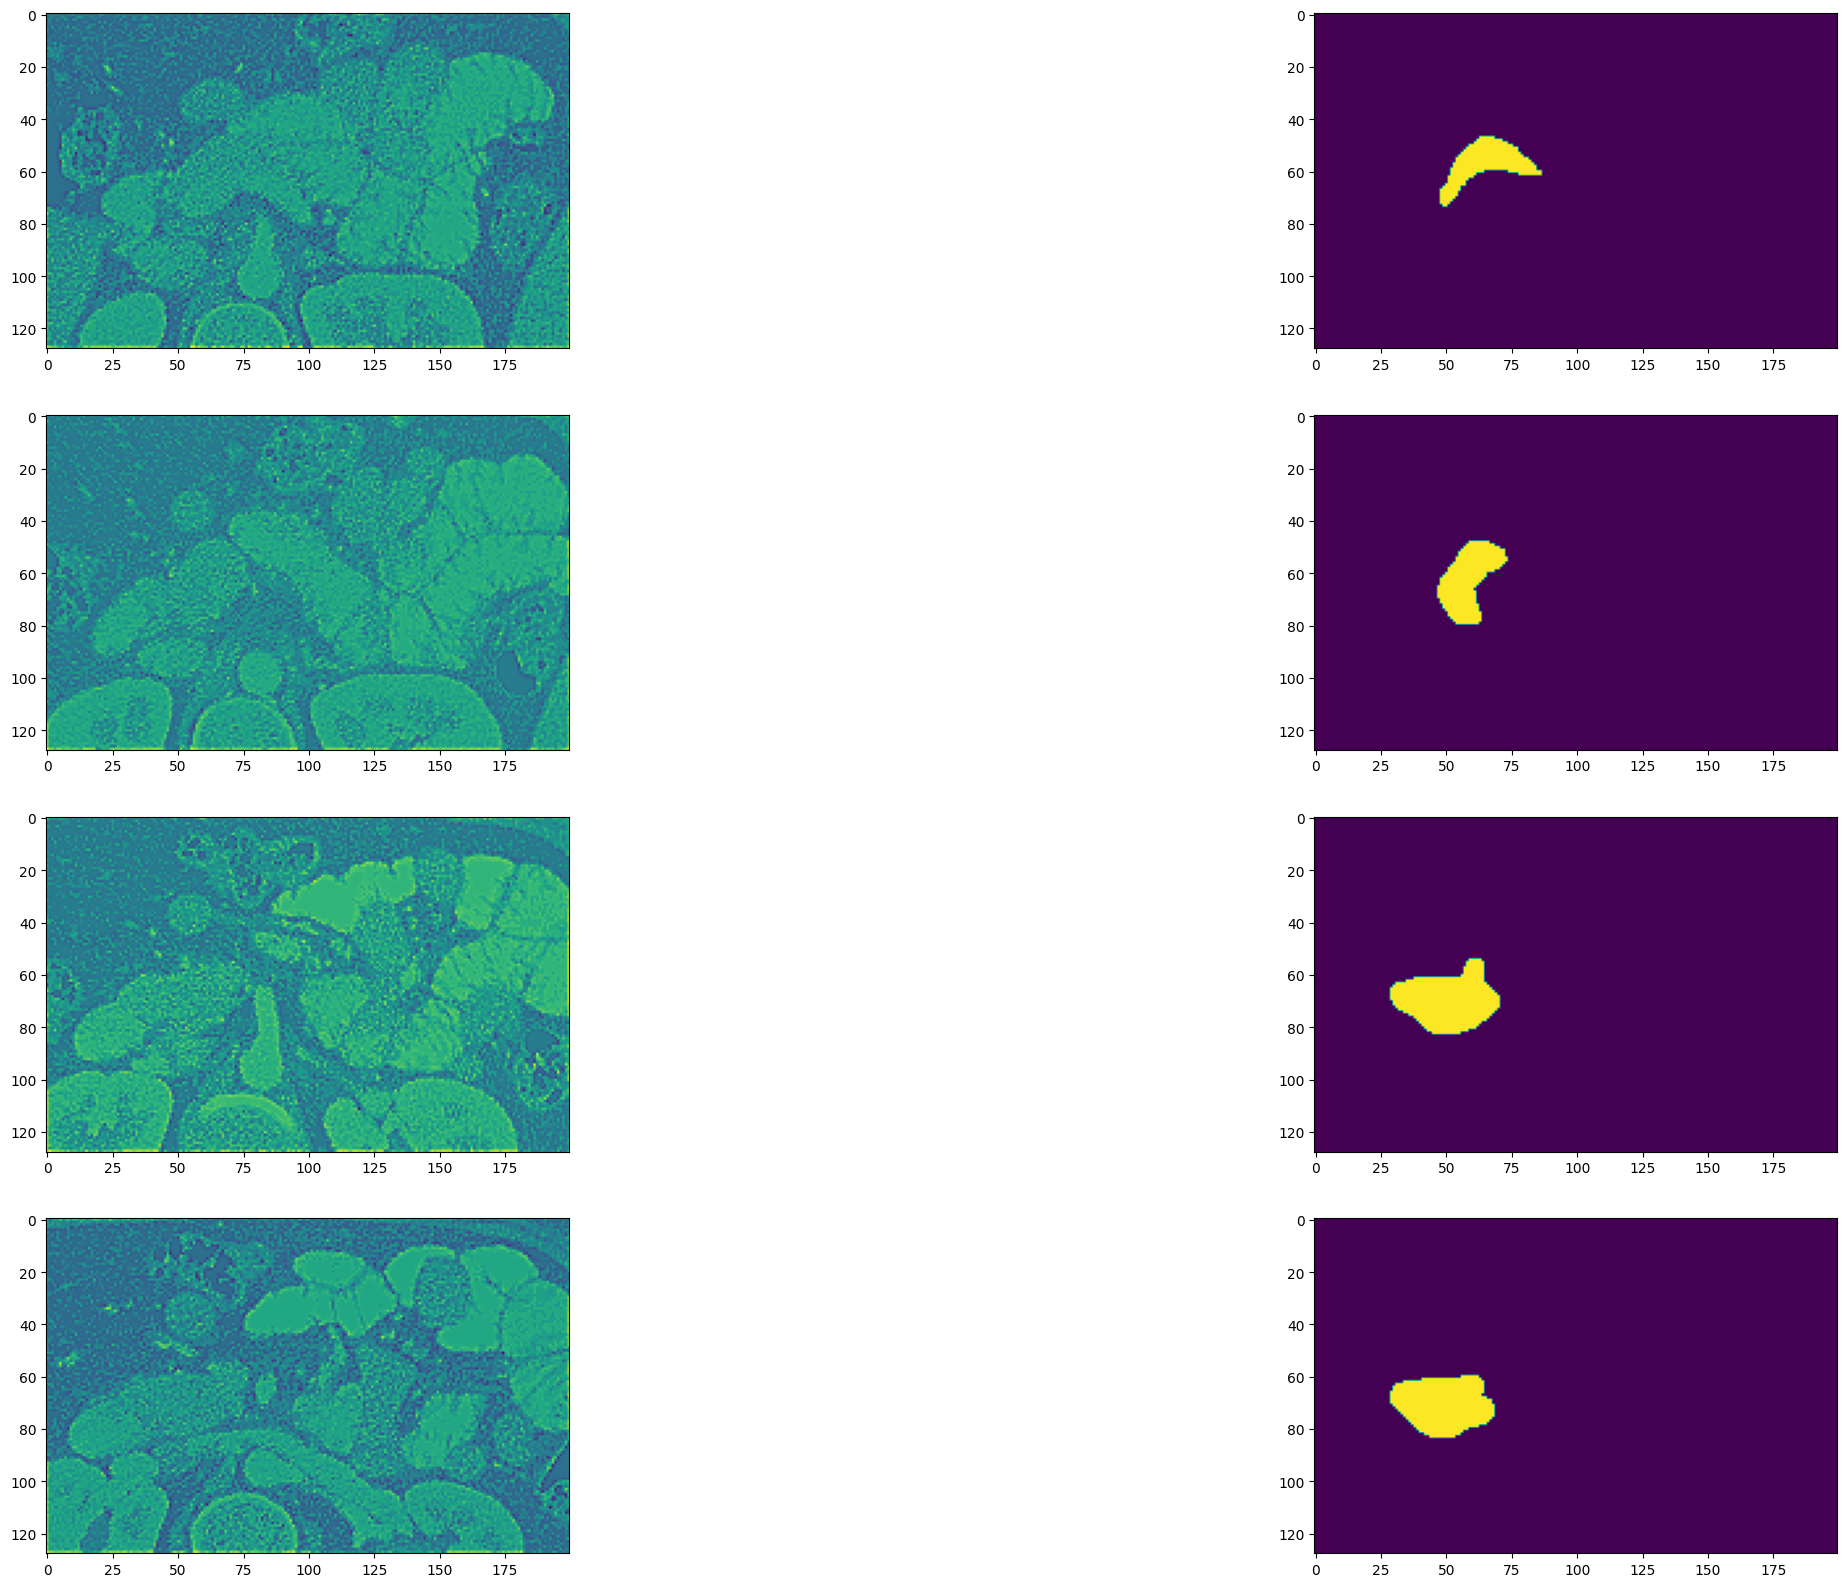

In [36]:
slice_no = [50, 60, 70, 80]
val=3
# Create a figure and subplots
plt.figure(figsize=(100, 60))
f, axarr = plt.subplots(len(slice_no), 2, figsize=(30, 20))

# Iterate over each slice number
for i in range(len(slice_no)):
    # Display the input image in the left subplot
    axarr[i][0].imshow(np.resize(X_val[val][0][slice_no[i]], (X_val.shape[3], X_val.shape[4], 1)))
    # Display the corresponding label image in the right subplot
    axarr[i][1].imshow(np.resize(y_val[val][0][slice_no[i]], (y_val.shape[3], y_val.shape[4], 1)))

<Figure size 10000x6000 with 0 Axes>

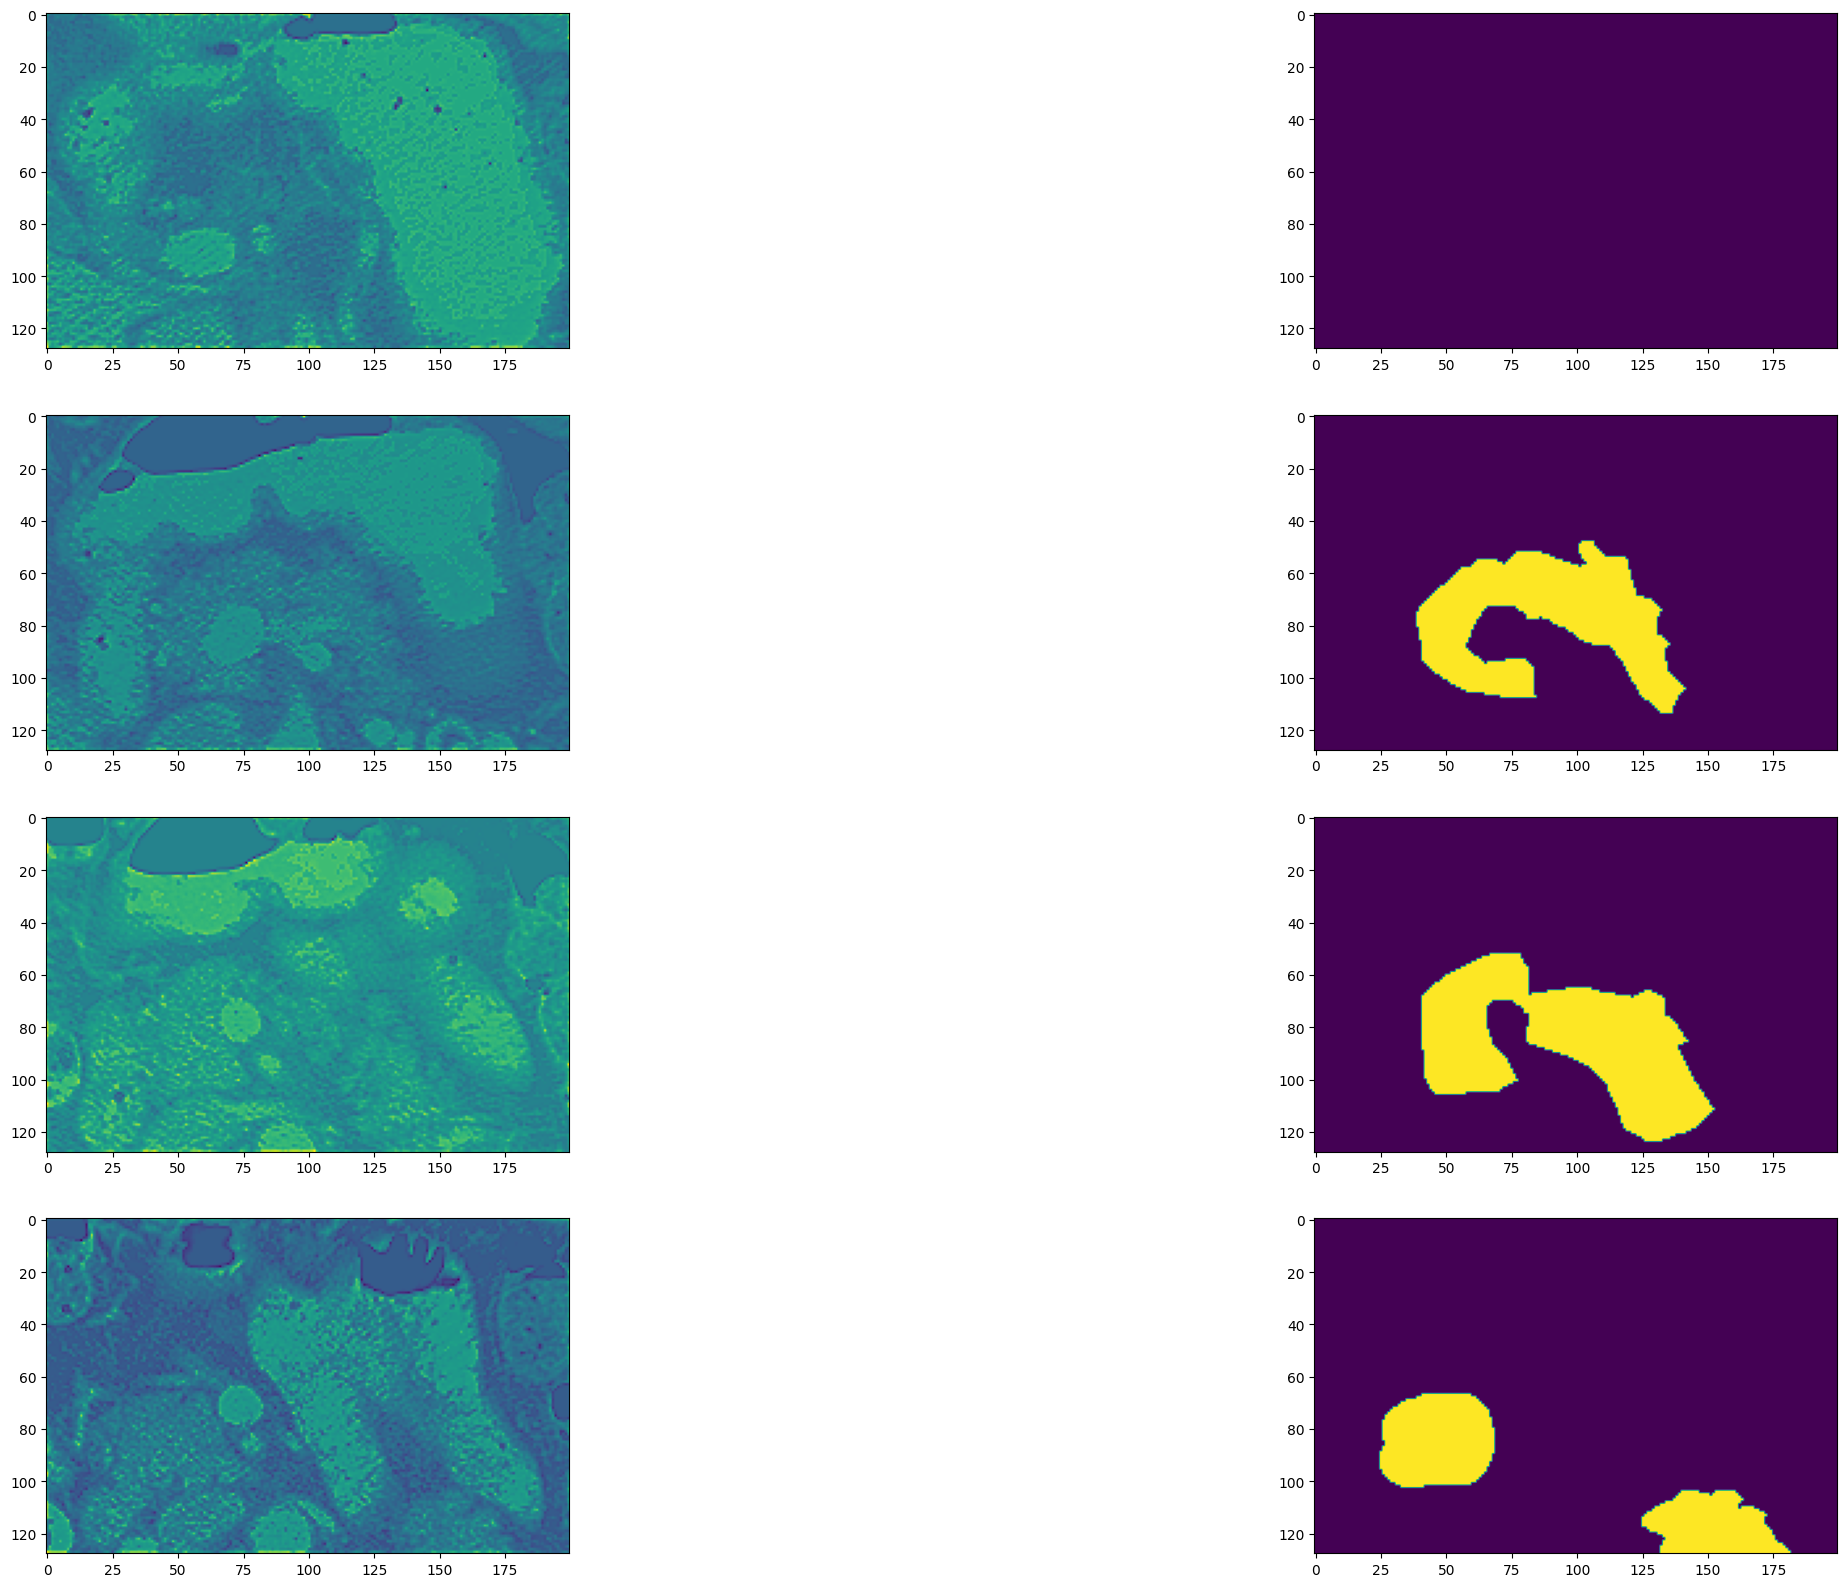

In [37]:
slice_no = [50, 60, 70, 80]
val=4
# Create a figure and subplots
plt.figure(figsize=(100, 60))
f, axarr = plt.subplots(len(slice_no), 2, figsize=(30, 20))

# Iterate over each slice number
for i in range(len(slice_no)):
    # Display the input image in the left subplot
    axarr[i][0].imshow(np.resize(X_val[val][0][slice_no[i]], (X_val.shape[3], X_val.shape[4], 1)))
    # Display the corresponding label image in the right subplot
    axarr[i][1].imshow(np.resize(y_val[val][0][slice_no[i]], (y_val.shape[3], y_val.shape[4], 1)))

def get_pixels_hu(image):
    #image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    #image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image=image[0]
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(image.shape[0]):
        
        intercept = image[slice_number].RescaleIntercept
        slope = image[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

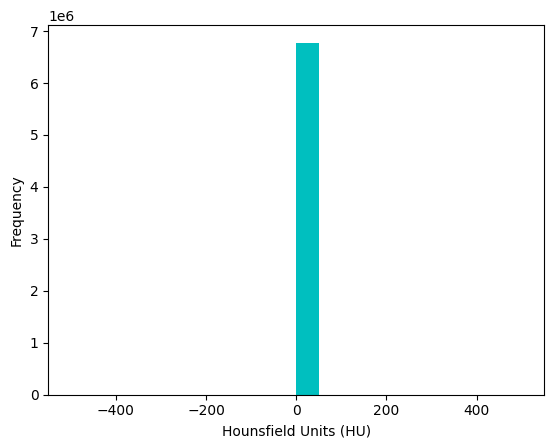

In [38]:
plt.hist((((X_train+2000)*y_train)-2000).flatten(), bins=20, color='c', range=[-500, 500])
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
#plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
#plt.show()

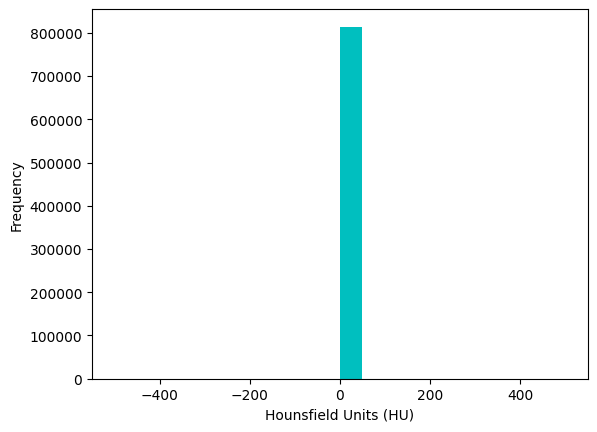

In [39]:
plt.hist((((X_test+2000)*y_test)-2000).flatten(), bins=20, color='c', range=[-500, 500])
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

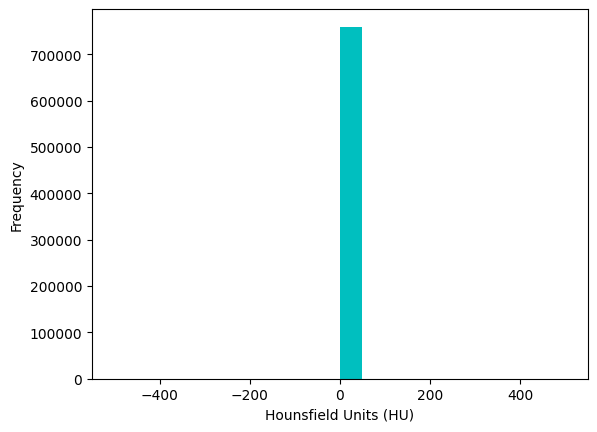

In [40]:
plt.hist((((X_val+2000)*y_val)-2000).flatten(), bins=20, color='c', range=[-500, 500])
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

In [41]:
# Convert NumPy arrays to PyTorch tensors
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)
X_val = torch.Tensor(X_val)
y_val = torch.Tensor(y_val)

In [42]:
class Conv3DBlock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, stride=1):
        """
        Constructor method for Conv3DBlock.

        Args:
        - in_channels: Number of input channels
        - out_channels: Number of output channels
        - kernel_size: Size of the convolutional kernel
        - padding: Padding added to the input during convolution
        - stride: Stride of the convolution
        """
        super(Conv3DBlock, self).__init__()
        
        # Define the convolutional layers
        self.conv1 = nn.Sequential(
            nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding, stride=stride),
            nn.BatchNorm3d(num_features=out_channels),
            nn.ReLU(),
            nn.Conv3d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm3d(num_features=out_channels),
            nn.ReLU()
        )

    def forward(self, input):
        # Perform the forward pass through the convolutional layers
        res = self.conv1(input)
        return res

In [43]:
class Conv3DBlockc(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, stride=1):
        """
        Constructor method for Conv3DBlockc.

        Args:
        - in_channels: Number of input channels
        - out_channels: Number of output channels
        - kernel_size: Size of the convolutional kernel
        - padding: Padding added to the input during convolution
        - stride: Stride of the convolution
        """
        super(Conv3DBlockc, self).__init__()

        # Define the convolutional layers
        self.conv1 = self.upconv1 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(2,2,2),padding=0, stride=(2,2,2)),
            nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding, stride=stride),
            nn.BatchNorm3d(num_features=out_channels),
            nn.ReLU(),
            nn.Conv3d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm3d(num_features=out_channels),
            nn.ReLU()
        )

    def forward(self, input):
        # Perform the forward pass through the convolutional layers
        res = self.conv1(input)
        return res

In [44]:
class Residual(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, stride=1):
        """
        Constructor method for Conv3DBlockc.

        Args:
        - in_channels: Number of input channels
        - out_channels: Number of output channels
        - kernel_size: Size of the convolutional kernel
        - padding: Padding added to the input during convolution
        - stride: Stride of the convolution
        """
        super(Residual, self).__init__()

        # Define the convolutional layers
        self.block1 = nn.Sequential(
            nn.Conv3d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm3d(num_features=out_channels),
            nn.ReLU(),
            nn.Conv3d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm3d(num_features=out_channels),
            nn.ReLU()
        )
        self.block2 = nn.Conv3d(in_channels=in_channels, out_channels=in_channels, kernel_size=1, padding=0, stride=1)
        self.block3=nn.ReLU()

    def forward(self, input):
        # Perform the forward pass through the convolutional layers
        res = self.block1(input)
        res2 = self.block2(input)
        res= self.block3(res+res2)
        return res

# Define an attention gate module
class attention_gate(nn.Module):
    def __init__(self, in_c, out_c):
        super(attention_gate, self).__init__()

        # Define the transformation functions Wg and Ws
        self.Wg = nn.Sequential(
            nn.Conv3d(in_c, out_c, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm3d(out_c)
        )
        self.Ws = nn.Sequential(
            nn.Conv3d(in_c, out_c, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm3d(out_c)
        )
        
        # Define the activation function
        self.relu = nn.ReLU(inplace=True)
        
        # Define the output transformation
        self.output = nn.Sequential(
            nn.Conv3d(out_c, out_c, kernel_size=3, padding=1, bias=True),
            nn.Sigmoid()
        )

    def forward(self, g, s):
        # Apply the transformation functions to the input tensors
        Wg = self.Wg(g)
        Ws = self.Ws(s)
        
        # Combine the transformed tensors and apply the activation function
        out = self.relu(Wg + Ws)
        
        # Apply the output transformation and return the result
        out = self.output(out)
        return out * s

In [45]:
# Define an attention gate module
class attention_gate(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(attention_gate, self).__init__()

        # Define the convolutional layers
        self.W_x = nn.Sequential(
            nn.Conv3d(in_channels=in_channels, out_channels=out_channels//2, kernel_size=1, padding=0, stride=1),
        )
        self.W_g = nn.Sequential(
            nn.Conv3d(in_channels=in_channels, out_channels=out_channels//2, kernel_size=1, padding=0, stride=1),
        )
        self.psi = nn.Conv3d(out_channels//2, 1, kernel_size=1, stride=1, padding=0, bias=True)
        self.bn = nn.BatchNorm3d(in_channels//2)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, g):
        """
        x: Skip connection input from encoder
        g: Gating signal from decoder
        """
        W_x = self.W_x(x)  # Downscale encoder input
        W_g = self.W_g(g)  # Downscale decoder input (gating signal)
        
        attention = self.relu(self.bn(W_x + W_g))  # Add and activate
        attention = self.sigmoid(self.psi(attention))  # Generate attention weights
        
        return x * attention

# Define an attention gate module
class attention_gate(nn.Module):
    def __init__(self, in_c, out_c):
        super(attention_gate, self).__init__()

        # Define the transformation functions Ws
        self.Ws = nn.Sequential(
            nn.Conv3d(in_c, out_c, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm3d(out_c),
            nn.LeakyReLU(0.2)
        )

    def forward(self, g, s):
        # Apply the transformation functions to the input tensors
        Ws = self.Ws(s)
        
        return Ws

In [46]:
# Define an upsampling convolutional block module
class UPConv3DBlock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, stride=1):
        super(UPConv3DBlock, self).__init__()

        # Define the layers of the upsampling convolutional block
        self.upconv1 = nn.Sequential(
            nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding, stride=stride),
            nn.BatchNorm3d(num_features=out_channels),
            nn.ReLU(),
            nn.Conv3d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm3d(num_features=out_channels),
            nn.ReLU()
        )

    def forward(self, input):
        # Forward pass through the upsampling convolutional block
        res = self.upconv1(input)
        return res

In [47]:
# Define an upsampling convolutional block module with trilinear interpolation
class UPConv3DBlockc(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, stride=1):
        super(UPConv3DBlockc, self).__init__()

        # Define the layers of the upsampling convolutional block with trilinear interpolation
        self.upconv1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True),
            nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm3d(num_features=out_channels),
            nn.ReLU(),
            nn.Conv3d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm3d(num_features=out_channels),
            nn.ReLU()
        )

    def forward(self, input):
        # Forward pass through the upsampling convolutional block
        res = self.upconv1(input)
        return res

In [48]:
# Define an upsampling convolutional block module with trilinear interpolation
class UPConv3DBlockc2(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, stride=1):
        super(UPConv3DBlockc2, self).__init__()

        # Define the layers of the upsampling convolutional block with trilinear interpolation
        self.upconv1 = nn.Sequential(
            nn.ConvTranspose3d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=(2,2,1)),
            nn.BatchNorm3d(num_features=out_channels),
            nn.ReLU(),
            nn.Conv3d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm3d(num_features=out_channels),
            nn.ReLU()
        )

    def forward(self, input):
        # Forward pass through the upsampling convolutional block
        res = self.upconv1(input)
        return res

In [49]:
# Define the UNet3D model
class UNET3D(nn.Module):
    # Define model elements
    def __init__(self, in_channels, out_channels):
        super(UNET3D, self).__init__()
        level = [8,16,32, 64, 128, 256]
        
        # Input batch normalization layer
        self.in1 = nn.BatchNorm3d(in_channels)

        # Encoding blocks
        self.a_block1 = Conv3DBlock(in_channels=in_channels, out_channels=level[0])
        self.r_block1 = Residual(in_channels=level[0], out_channels=level[0])
        
        # Pooling blocks
        self.p_block2 = Conv3DBlockc(in_channels=level[0], out_channels=level[1])
        self.d_block2 = Residual(in_channels=level[1], out_channels=level[1])
        
        self.p_block3 = Conv3DBlockc(in_channels=level[1], out_channels=level[2])
        self.d_block3 = Residual(in_channels=level[2], out_channels=level[2])
        
        # Dropout layers
        self.drop = nn.Dropout(0.0)
        self.drop1 = nn.Dropout(0.0)
        self.drop2 = nn.Dropout(0.0)
        self.drop3 = nn.Dropout(0.0)
        self.drop4 = nn.Dropout(0.0)
        
        # Decoding blocks
        
        self.d_block4 = Residual(in_channels=level[2], out_channels=level[2])
        self.b_block1 = UPConv3DBlock(in_channels=level[2], out_channels=level[2])
        
        self.d_block5 = Residual(in_channels=level[2], out_channels=level[2])
        self.u_block2 = UPConv3DBlockc(in_channels=level[2], out_channels=level[1])
        self.att1 = attention_gate(level[1], level[1])
        
        self.d_block6 = Residual(in_channels=level[1], out_channels=level[1])
        self.u_block3 = UPConv3DBlockc(in_channels=level[1], out_channels=level[0])
        self.att2 = attention_gate(level[0], level[0])
        
        # Final decoding blocks
        self.d_block7 = Residual(in_channels=level[0], out_channels=level[0])
        self.b_block4 = UPConv3DBlock(in_channels=level[0], out_channels=level[0])
        
        # Final convolution and sigmoid activation
        self.b_block5 = UPConv3DBlock(in_channels=level[0], out_channels=level[0])
        self.out = nn.Conv3d(in_channels=level[0], out_channels=out_channels, kernel_size=3, padding=1, stride=1)
        self.sigmoid_layer = nn.Sigmoid()
    
    # Forward propagate input
    def forward(self, inputs):
        conv1 = self.in1(self.drop(inputs))
        # Encoding path]

        conv1=self.a_block1(conv1)
        conv1=self.r_block1(conv1)
        
        conv2=self.p_block2(conv1)
        conv2=self.d_block2(conv2)
        
        conv3=self.p_block3(conv2)
        conv3=self.d_block3(conv3)

        conv3=self.d_block4(conv3)
        conv3=self.b_block1(conv3)
        
        conv3=self.d_block5(conv3)
        convt=self.u_block2(conv3)
        convt=self.att1(conv2,convt)
        
        convt=self.d_block6(convt)
        convt=self.u_block3(convt)
        
        convt=self.att2(conv1,convt)
        
        convt=self.d_block7(convt)
        convt=self.b_block4(convt)
        
        convt=self.b_block5(convt)
        convt=self.out(convt)
        out=self.sigmoid_layer(convt)

        return out

In [50]:
torch.cuda.is_available()

True

In [51]:
torch.cuda.device_count()

1

In [52]:
# Create an instance of the UNet3D model
model = UNET3D(in_channels=1, out_channels=1)

# Move the model to CUDA (GPU)
model.cuda()

# Display the summary of the model
summary(model=model, input_size=(1, im_depth1, im_height1, im_width1), batch_size=1, device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1      [1, 1, 128, 128, 200]               0
       BatchNorm3d-2      [1, 1, 128, 128, 200]               2
            Conv3d-3      [1, 8, 128, 128, 200]             224
       BatchNorm3d-4      [1, 8, 128, 128, 200]              16
              ReLU-5      [1, 8, 128, 128, 200]               0
            Conv3d-6      [1, 8, 128, 128, 200]           1,736
       BatchNorm3d-7      [1, 8, 128, 128, 200]              16
              ReLU-8      [1, 8, 128, 128, 200]               0
       Conv3DBlock-9      [1, 8, 128, 128, 200]               0
           Conv3d-10      [1, 8, 128, 128, 200]           1,736
      BatchNorm3d-11      [1, 8, 128, 128, 200]              16
             ReLU-12      [1, 8, 128, 128, 200]               0
           Conv3d-13      [1, 8, 128, 128, 200]           1,736
      BatchNorm3d-14      [1, 8, 128, 1

In [53]:
def initialize_weights(model):
    """
    Initializes weights according to a specific scheme for certain types of layers in the RCNN model.

    Args:
    - model: The RCNN model

    Returns:
    - None
    """
    # Iterate over all modules in the model
    for m in model.modules():
        # Check if the module is an instance of Conv3d and ConvTranspose3d
        if isinstance(m, (nn.Conv3d, nn.ConvTranspose3d,nn.BatchNorm3d)):
            # Initialize weights of the module's weight data with normal distribution
            # Mean = 0.0, Standard deviation = 0.6
            nn.init.normal_(m.weight.data, 0.0, 0.6)

In [54]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets):
        # Flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        # Calculate intersection and dice coefficient
        intersection = (inputs * targets).sum()
        dice = (2. * intersection) / (inputs.sum() + targets.sum())

        # Return 1 - dice coefficient as loss
        return 1 - dice

In [55]:
class Dice(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(Dice, self).__init__()

    def forward(self, inputs, targets):
        # Flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        # Calculate intersection and dice coefficient
        intersection = (inputs * targets).sum()
        dice = (2. * intersection) / (inputs.sum() + targets.sum())

        # Return 1 - dice coefficient as loss
        return dice

In [56]:
class Precision(nn.Module):
    def __init__(self, epsilon=1e-6):
        super(Precision, self).__init__()
        self.epsilon = epsilon

    def forward(self, predictions, targets):
        # Calculate true positives and false positives
        true_positives = torch.sum(predictions * targets)
        false_positives = torch.sum(predictions) - true_positives

        # Calculate precision
        precision = true_positives / (true_positives + false_positives + self.epsilon)
        return precision

In [57]:
class Recall(nn.Module):
    def __init__(self, epsilon=1e-6):
        super(Recall, self).__init__()
        self.epsilon = epsilon

    def forward(self, predictions, targets):
        # Calculate true positives and false negatives
        true_positives = torch.sum(predictions * targets)
        false_negatives = torch.sum(targets) - true_positives

        # Calculate recall
        recall = true_positives / (true_positives + false_negatives + self.epsilon)
        return recall

In [58]:
class IoU(nn.Module):
    def __init__(self, epsilon=1e-6):
        super(IoU, self).__init__()
        self.epsilon = epsilon

    def forward(self, predictions, targets):
        # Calculate intersection and union
        intersection = torch.sum(predictions * targets)
        union = torch.sum(predictions) + torch.sum(targets) - intersection

        # Calculate IoU
        iou = (intersection + self.epsilon) / (union + self.epsilon)
        return iou

In [59]:
# Define the optimization criteria and optimizer

# Use Dice Loss as the optimization criterion
criterion = DiceLoss()

# Alternatively, you can use other custom loss functions such as Precision, Recall, or IoU
criterion0 = Dice()
criterion1 = Precision()
criterion2 = Recall()
criterion3 = IoU()
# Define the primary loss function (Binary Cross Entropy Loss)
criterion4 = nn.BCELoss()

#criterion=nn.L1Loss()
#criterion =torch.nn.MSELoss()

# Define the optimizer
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.99)

# Evaluate the model

In [60]:
BATCH_SIZE=1

import pydensecrf.densecrf as dcrf
import numpy as np
from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral

# Assume `probabilities` is the softmax output of the 3D U-Net with shape (C, D, H, W)
# where C is the number of classes, D is depth, H is height, and W is width.

def apply_crf(probabilities, img, num_classes):
    # Create unary potentials
    unary = unary_from_softmax(probabilities)
    unary = np.ascontiguousarray(unary)
    
    # Create the CRF model
    d, h, w = img.shape
    crf = dcrf.DenseCRF3D(w, h, d, num_classes)

    crf.setUnaryEnergy(unary)
    
    # Add pairwise energy
    pairwise_bilateral = create_pairwise_bilateral(sdims=(1.0, 1.0, 1.0), schan=(0.01,), img=img, chdim=0)
    crf.addPairwiseEnergy(pairwise_bilateral, compat=10)

    # Run inference
    Q = crf.inference(5)

    # Get the most probable class for each voxel
    result = np.argmax(Q, axis=0).reshape((d, h, w))

    return result

# Usage:
# `probabilities` is the output of your 3D U-Net
# `image` is the original 3D image
segmented_image = apply_crf(probabilities, image, num_classes=2)


import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral_3d

def apply_crf_3d(volume, segmentation_probs):
    """
    Apply Conditional Random Fields (CRF) to refine 3D image segmentation.
    
    Args:
        volume (numpy array): Original 3D image data (DxHxW).
        segmentation_probs (numpy array): Segmentation probability map (CxDxHxW).

    Returns:
        numpy array: Refined segmentation map (DxHxW).
    """
    d, h, w = volume.shape
    n_classes = segmentation_probs.shape[0]
    
    # Initialize 3D CRF model
    d = dcrf.DenseCRF3D(w, h, d, n_classes)
    
    # Convert the softmax output to unary potentials
    unary = unary_from_labels(segmentation_probs)
    d.setUnaryEnergy(unary)
    
    # Create pairwise potentials using bilateral filter
    pairwise_energy = create_pairwise_bilateral_3d(sdims=(10, 10, 10), schan=(5,), img=volume)
    d.addPairwiseEnergy(pairwise_energy, compat=10)
    
    # Perform inference (10 iterations)
    refined_probs = d.inference(10)
    
    # Convert the output to a segmentation map
    refined_segmentation = np.argmax(refined_probs, axis=0).reshape(d, h, w)
    
    return refined_segmentation


In [61]:
def haar_wave(image_3d):
    # Apply 3D Haar wavelet transform using PyWavelets
    coeffs = pywt.dwtn(image_3d, 'haar', axes=(0, 1, 2))

    # coeffs contains approximation and detail coefficients
    # Approximation coefficients (low-pass filtering on all axes)
    
    approximation = np.concatenate((coeffs['aaa'],coeffs['aad'],coeffs['ada'],coeffs['aad']))
    
    return torch.Tensor(approximation)

In [62]:
# enumerate epochs
lrate=0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=lrate, weight_decay=1e-10)
MIN_LOSS = 10
# Lists to store losses
loss_DICE = []
loss_PRE = []
loss_REC = []
loss_IOU = []
loss_BIN = []

test_loss_DICE = []
test_loss_PRE = []
test_loss_REC = []
test_loss_IOU = []
test_loss_BIN = []

val_loss_DICE = []
val_loss_PRE = []
val_loss_REC = []
val_loss_IOU = []
val_loss_BIN = []

loss_checkpoint=0
epochs=100
l1=0
change_lr=0
val_lr=5
for epoch in range(epochs):
    b = "Loading "
    count=0
    loss=0
    test_loss=0
    val_loss=0
    
    loss1=0
    test_loss1=0
    val_loss1=0
    
    loss2=0
    test_loss2=0
    val_loss2=0
    
    loss3=0
    test_loss3=0
    val_loss3=0
    
    loss4=0
    test_loss4=0
    val_loss4=0
    
    # enumerate mini batches
    model.train()
    for i in range(0,trainImages):
        # clear the gradients
        optimizer.zero_grad()
        # compute the model output
        inputs=Variable(X_train[i],requires_grad=True).type(dtype)
        targets=Variable(y_train[i].unsqueeze(0)).type(dtype)
        yhat = model(inputs.unsqueeze(0))
        
        # Calculate DICE loss
        loss_bcd = criterion(yhat, targets)
        
        # Credit assignment
        loss_bcd.backward()
        optimizer.step()
    model.eval()
    
    for i in range(0,trainImages):
        #print(b,i+1,"               ", end="\r")
        inputs=Variable(X_train[i],requires_grad=True).type(dtype)
        targets=Variable(y_train[i].unsqueeze(0)).type(dtype)
        
        yhat = model(inputs.unsqueeze(0))
        yhat=(yhat>0.5)*1.0
        loss_bcd = criterion(yhat, targets)
        loss+=loss_bcd.cpu().detach().numpy()

    b = "Loss Loading "
    # evaluate the model
    loss=0
    for i in range(0,trainImages):
        #print(b,i+1,"               ", end="\r")
        inputs=Variable(X_train[i],requires_grad=True).type(dtype)
        targets=Variable(y_train[i].unsqueeze(0)).type(dtype)
        
        yhat = model(inputs.unsqueeze(0))
        yhat=(yhat>0.5)*1.0
        loss_bcd = criterion0(yhat, targets)
        loss+=loss_bcd.cpu().detach().numpy()
        
        
        loss_bcd = criterion1(yhat, targets)
        loss1+=loss_bcd.cpu().detach().numpy()
        
        
        loss_bcd = criterion2(yhat, targets)
        loss2+=loss_bcd.cpu().detach().numpy()
        
        
        loss_bcd = criterion3(yhat, targets)
        loss3+=loss_bcd.cpu().detach().numpy()
        
        loss_bcd = criterion4(yhat, targets)
        loss4+=loss_bcd.cpu().detach().numpy()

        """
    if(epoch<1):
        lr_threhold=0.01
    elif(epoch<5):
        lr_threhold=0.005
    elif(epoch<15):
        lr_threhold=0.003
    elif(epoch<25):
        lr_threhold=0.001
    elif(epoch<50):
        lr_threhold=0.0005
    elif(epoch<60):
        lr_threhold=0.0005
    if ((loss/trainImages)-l1)<lr_threhold:
        change_lr=change_lr+1
        if(change_lr>=val_lr):
            change_lr=0
            lrate=lrate/2
            print("\n\nLearning rate: ",lrate,"\n\n")
            optimizer = SGD(model.parameters(), lr=lrate, momentum=0.99,weight_decay=1e-10)
    else:
        change_lr=0"""
    """
    if 0.70<(loss/trainImages):
        val_lr=7
    if l1<(loss/trainImages):
        l1=(loss/trainImages)
    else:
        change_lr+=2"""
        
        
    for i in range(trainImages, trainImages + testImages):
        inputs=Variable(X_test[i-trainImages],requires_grad=True).type(dtype)
        targets=Variable(y_test[i-trainImages].unsqueeze(0)).type(dtype)
        yhat = model(inputs.unsqueeze(0))
        yhat=(yhat>0.5)*1.0
        
        loss_bcd = criterion0(yhat, targets)
        test_loss+=loss_bcd.cpu().detach().numpy()    
        
        loss_bcd = criterion1(yhat, targets)
        test_loss1+=loss_bcd.cpu().detach().numpy() 
        
        loss_bcd = criterion2(yhat, targets)
        test_loss2+=loss_bcd.cpu().detach().numpy() 
        
        loss_bcd = criterion3(yhat, targets)
        test_loss3+=loss_bcd.cpu().detach().numpy()
        
        loss_bcd = criterion4(yhat, targets)
        test_loss4+=loss_bcd.cpu().detach().numpy()
    
    for i in range(trainImages + testImages, trainImages + testImages + valImages):
        inputs=Variable(X_val[i-trainImages-testImages],requires_grad=True).type(dtype)
        targets=Variable(y_val[i-trainImages-testImages].unsqueeze(0)).type(dtype)
        yhat = model(inputs.unsqueeze(0))
        yhat=(yhat>0.5)*1.0
        
        loss_bcd = criterion0(yhat, targets)
        val_loss+=loss_bcd.cpu().detach().numpy()    
        
        loss_bcd = criterion1(yhat, targets)
        val_loss1+=loss_bcd.cpu().detach().numpy() 
        
        loss_bcd = criterion2(yhat, targets)
        val_loss2+=loss_bcd.cpu().detach().numpy() 
        
        loss_bcd = criterion3(yhat, targets)
        val_loss3+=loss_bcd.cpu().detach().numpy()
        
        loss_bcd = criterion4(yhat, targets)
        val_loss4+=loss_bcd.cpu().detach().numpy()
        
    print("\n",epoch,"Training loss Dice",((loss*BATCH_SIZE)/trainImages),", Precision",((loss1*BATCH_SIZE)/trainImages),
          ", Recall",((loss2*BATCH_SIZE)/trainImages),", IOU",(loss3*BATCH_SIZE)/trainImages,", Binary Cross Entropy",(loss4*BATCH_SIZE)/trainImages,
          
          "Testing loss Dice:",test_loss/testImages,", Precision",test_loss1/testImages,
          ", Recall",test_loss2/testImages,", IOU",test_loss3/testImages,", Binary Cross entropy",test_loss4/testImages,
          
          "Validation loss Dice:",val_loss/valImages,", Precision",val_loss1/valImages,
          ", Recall",val_loss2/valImages,", IOU",val_loss3/valImages,", Binary Cross entropy",val_loss4/valImages)
    loss_DICE.append(((loss*BATCH_SIZE)/trainImages))
    loss_PRE.append((loss1*BATCH_SIZE)/trainImages)
    loss_REC.append((loss2*BATCH_SIZE)/trainImages)
    loss_IOU.append((loss3*BATCH_SIZE)/trainImages)
    loss_BIN.append((loss4*BATCH_SIZE)/trainImages)
    
    test_loss_DICE.append(test_loss/testImages)
    test_loss_PRE.append(test_loss1/testImages)
    test_loss_REC.append(test_loss2/testImages)
    test_loss_IOU.append(test_loss3/testImages)
    test_loss_BIN.append(test_loss4/testImages)
    
    val_loss_DICE.append(val_loss/valImages)
    val_loss_PRE.append(val_loss1/valImages)
    val_loss_REC.append(val_loss2/valImages)
    val_loss_IOU.append(val_loss3/valImages)
    val_loss_BIN.append(val_loss4/valImages)


    if (test_loss/testImages)>loss_checkpoint:
        loss_checkpoint=(test_loss/testImages)
        model=torch.jit.script(model)
        model.save('checkpoint_unet.pt')
        print("Model saved")


 0 Training loss Dice 0.1136481373859941 , Precision 0.06765978714374245 , Recall 0.475663380994733 , IOU 0.06225501533975405 , Binary Cross Entropy 21.258063807631984 Testing loss Dice: 0.07378767287445953 , Precision 0.042357176418590825 , Recall 0.3525324091606308 , IOU 0.039556853438625694 , Binary Cross entropy 18.769038915634155 Validation loss Dice: 0.101039144967217 , Precision 0.06334344658534974 , Recall 0.3778716587112285 , IOU 0.055132157169282436 , Binary Cross entropy 18.230777740478516
Model saved

 1 Training loss Dice 0.12919542572864995 , Precision 0.07257026636745484 , Recall 0.6973160385078341 , IOU 0.0709706585673275 , Binary Cross Entropy 28.567409457582414 Testing loss Dice: 0.06617758781067096 , Precision 0.036360432612127624 , Recall 0.44631265092175454 , IOU 0.03516816039336845 , Binary Cross entropy 29.606421947479248 Validation loss Dice: 0.11029499000869691 , Precision 0.06076809304067865 , Recall 0.6402106359601021 , IOU 0.05959418922429904 , Binary Cross

In [63]:
model=torch.jit.load('checkpoint_unet.pt')

In [64]:
count=0
loss=0
test_loss=0
val_loss=0

loss1=0
test_loss1=0
val_loss1=0

loss2=0
test_loss2=0
val_loss2=0

loss3=0
test_loss3=0
val_loss3=0

loss4=0
test_loss4=0
val_loss4=0
# evaluate the model
for i in range(0,trainImages):
    #print(b,i+1,"               ", end="\r")
    inputs=Variable(X_train[i]).type(dtype)
    targets=Variable(y_train[i].unsqueeze(0)).type(dtype)

    yhat = model(inputs.unsqueeze(0))
    yhat=(yhat>0.5)*1.0
    loss_bcd = criterion0(yhat, targets)
    loss+=loss_bcd.cpu().detach().numpy()


    loss_bcd = criterion1(yhat, targets)
    loss1+=loss_bcd.cpu().detach().numpy()


    loss_bcd = criterion2(yhat, targets)
    loss2+=loss_bcd.cpu().detach().numpy()


    loss_bcd = criterion3(yhat, targets)
    loss3+=loss_bcd.cpu().detach().numpy()
    
    loss_bcd = criterion4(yhat, targets)
    loss4+=loss_bcd.cpu().detach().numpy()

for i in range(trainImages,trainImages + testImages):
    inputs=Variable(X_test[i-trainImages]).type(dtype)
    targets=Variable(y_test[i-trainImages].unsqueeze(0)).type(dtype)
    yhat = model(inputs.unsqueeze(0))
    yhat=(yhat>0.5)*1.0
    loss_bcd = criterion0(yhat, targets)
    test_loss+=loss_bcd.cpu().detach().numpy()    

    loss_bcd = criterion1(yhat, targets)
    test_loss1+=loss_bcd.cpu().detach().numpy() 

    loss_bcd = criterion2(yhat, targets)
    test_loss2+=loss_bcd.cpu().detach().numpy() 

    loss_bcd = criterion3(yhat, targets)
    test_loss3+=loss_bcd.cpu().detach().numpy()

    loss_bcd = criterion4(yhat, targets)
    test_loss4+=loss_bcd.cpu().detach().numpy()
    
for i in range(trainImages + testImages,trainImages + testImages+ valImages):
    inputs=Variable(X_val[i-trainImages-testImages]).type(dtype)
    targets=Variable(y_val[i-trainImages-testImages].unsqueeze(0)).type(dtype)
    yhat = model(inputs.unsqueeze(0))
    yhat=(yhat>0.5)*1.0
    loss_bcd = criterion0(yhat, targets)
    val_loss+=loss_bcd.cpu().detach().numpy()    

    loss_bcd = criterion1(yhat, targets)
    val_loss1+=loss_bcd.cpu().detach().numpy() 

    loss_bcd = criterion2(yhat, targets)
    val_loss2+=loss_bcd.cpu().detach().numpy() 

    loss_bcd = criterion3(yhat, targets)
    val_loss3+=loss_bcd.cpu().detach().numpy()

    loss_bcd = criterion4(yhat, targets)
    val_loss4+=loss_bcd.cpu().detach().numpy()

print("\n","Training loss Dice",((loss*BATCH_SIZE)/trainImages),", Precision",((loss1*BATCH_SIZE)/trainImages),
          ", Recall",((loss2*BATCH_SIZE)/trainImages),", IOU",(loss3*BATCH_SIZE)/trainImages,", Binary Cross Entropy",(loss4*BATCH_SIZE)/trainImages,
      
      "Testing loss Dice:",test_loss/testImages,", Precision",test_loss1/testImages,
          ", Recall",test_loss2/testImages,", IOU",test_loss3/testImages,", Binary Cross entropy",test_loss4/testImages,
          
          "Validation loss Dice:",val_loss/valImages,", Precision",val_loss1/valImages,
          ", Recall",val_loss2/valImages,", IOU",val_loss3/valImages,", Binary Cross entropy",val_loss4/valImages)


 Training loss Dice 0.36224397771848366 , Precision 0.5354501291547588 , Recall 0.3537179728982389 , IOU 0.2785978883817082 , Binary Cross Entropy 2.530781601414536 Testing loss Dice: 0.22225466347299516 , Precision 0.27762913797050714 , Recall 0.20195333543233573 , IOU 0.1709954269558568 , Binary Cross entropy 2.8867759704589844 Validation loss Dice: 0.17484160237654578 , Precision 0.39455924442154355 , Recall 0.1802186201675795 , IOU 0.1252821714742729 , Binary Cross entropy 3.4147186279296875


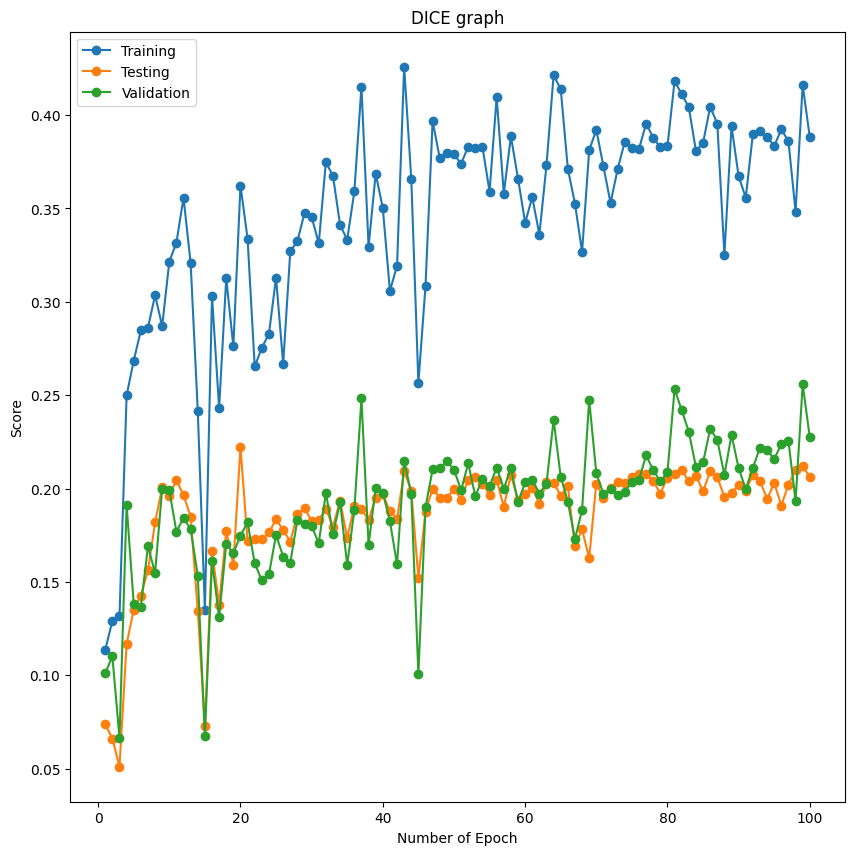

In [65]:
plt.figure(figsize=(10,10))
plt.xlabel("Number of Epoch")
plt.ylabel("Score")
plt.title("DICE graph")
plt.plot( [i+1 for i in range(0,epochs)],loss_DICE, marker='o', linestyle='-')
plt.plot( [i+1 for i in range(0,epochs)],test_loss_DICE, marker='o', linestyle='-')
plt.plot( [i+1 for i in range(0,epochs)],val_loss_DICE, marker='o', linestyle='-')
plt.legend(['Training','Testing','Validation'],loc='upper left')
plt.show()

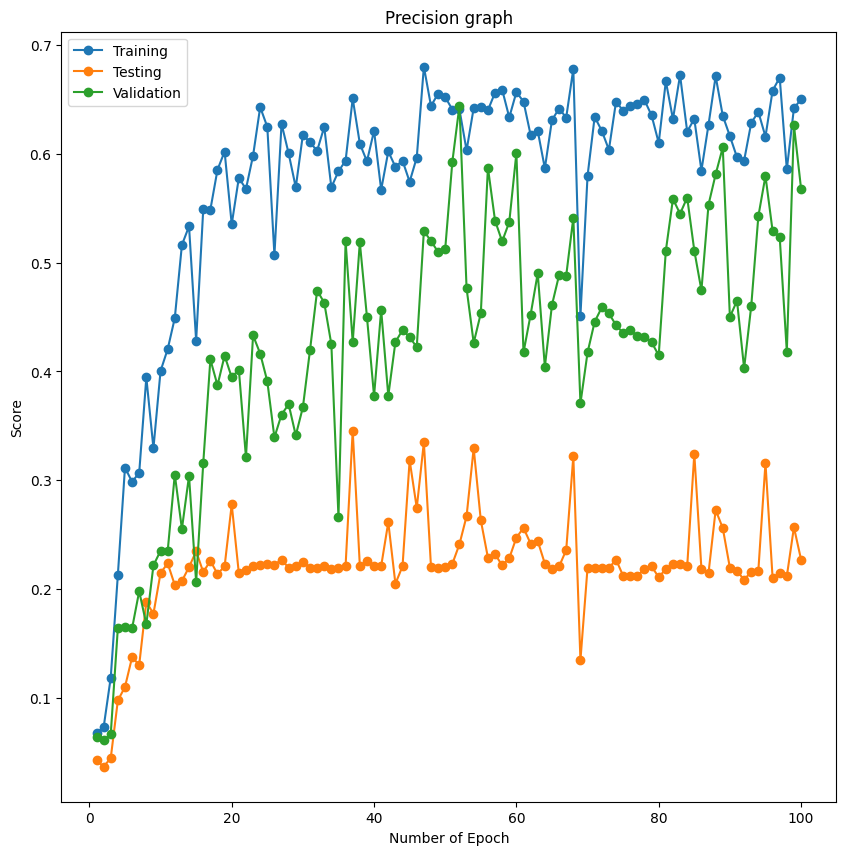

In [66]:
plt.figure(figsize=(10,10))
plt.xlabel("Number of Epoch")
plt.ylabel("Score")
plt.title("Precision graph")
plt.plot( [i+1 for i in range(0,epochs)],loss_PRE, marker='o', linestyle='-')
plt.plot( [i+1 for i in range(0,epochs)],test_loss_PRE, marker='o', linestyle='-')
plt.plot( [i+1 for i in range(0,epochs)],val_loss_PRE, marker='o', linestyle='-')
plt.legend(['Training','Testing','Validation'],loc='upper left')
plt.show()

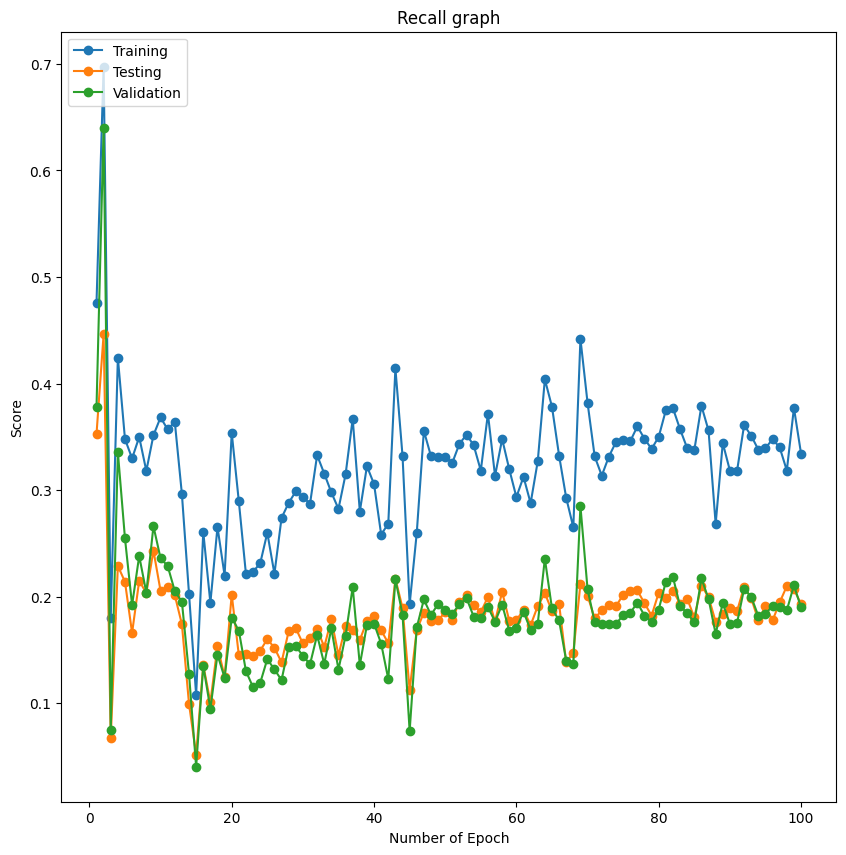

In [67]:
plt.figure(figsize=(10,10))
plt.xlabel("Number of Epoch")
plt.ylabel("Score")
plt.title("Recall graph")
plt.plot( [i+1 for i in range(0,epochs)],loss_REC, marker='o', linestyle='-')
plt.plot( [i+1 for i in range(0,epochs)],test_loss_REC, marker='o', linestyle='-')
plt.plot( [i+1 for i in range(0,epochs)],val_loss_REC, marker='o', linestyle='-')
plt.legend(['Training','Testing','Validation'],loc='upper left')
plt.show()

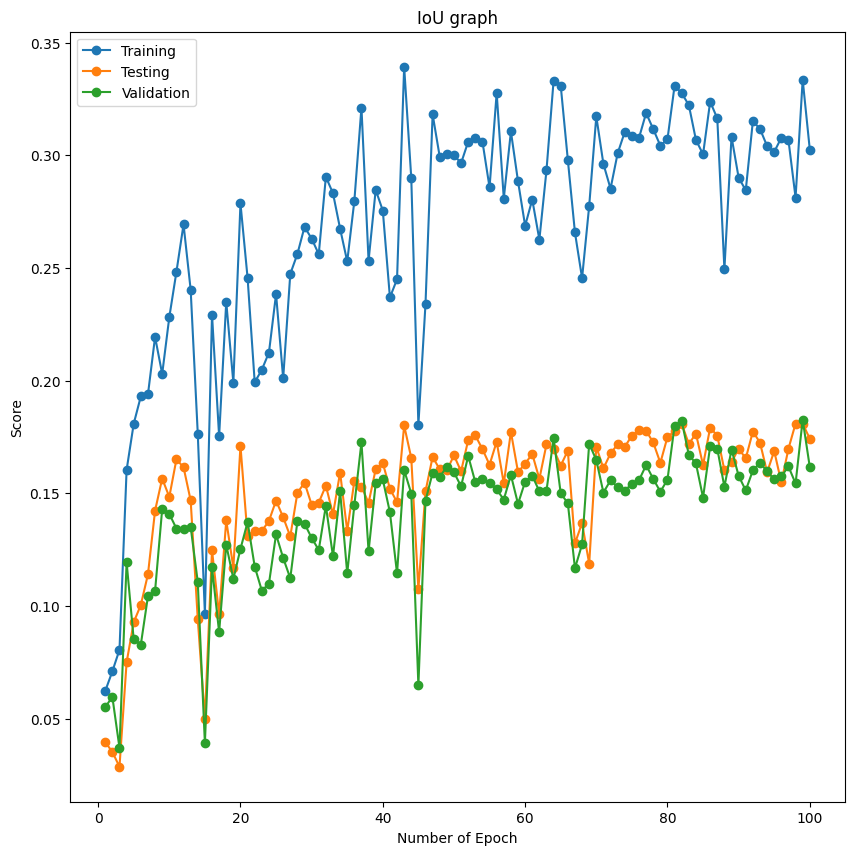

In [68]:
plt.figure(figsize=(10,10))
plt.xlabel("Number of Epoch")
plt.ylabel("Score")
plt.title("IoU graph")
plt.plot( [i+1 for i in range(0,epochs)],loss_IOU, marker='o', linestyle='-')
plt.plot( [i+1 for i in range(0,epochs)],test_loss_IOU, marker='o', linestyle='-')
plt.plot( [i+1 for i in range(0,epochs)],val_loss_IOU, marker='o', linestyle='-')
plt.legend(['Training','Testing','Validation'],loc='upper left')
plt.show()

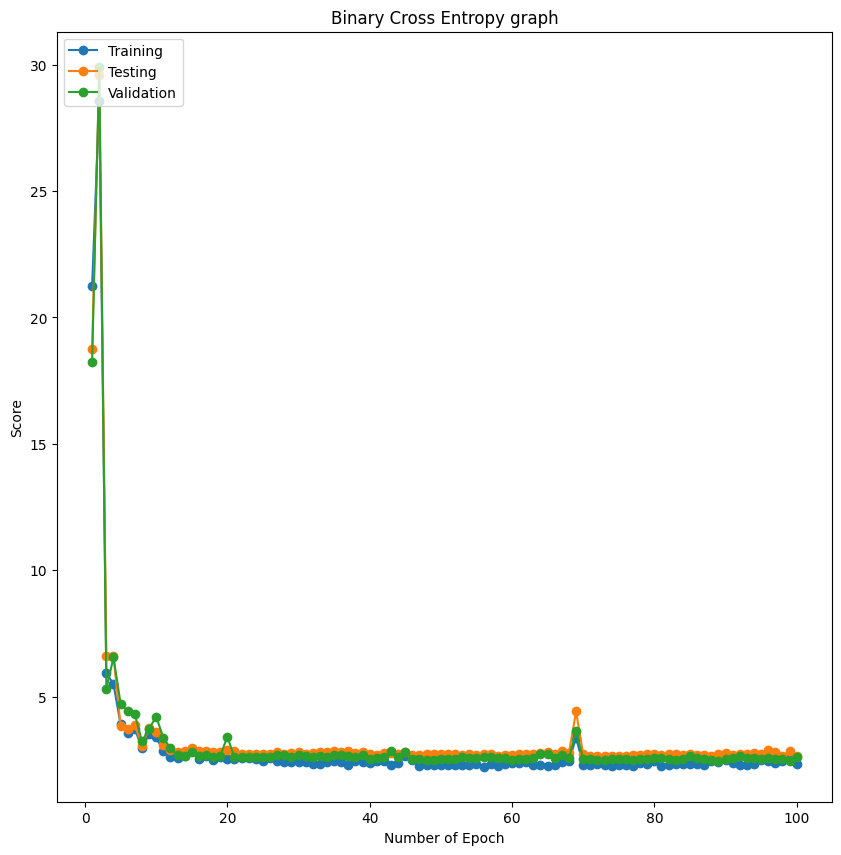

In [69]:
plt.figure(figsize=(10,10))
plt.xlabel("Number of Epoch")
plt.ylabel("Score")
plt.title("Binary Cross Entropy graph")
plt.plot( [i+1 for i in range(0,epochs)],loss_BIN, marker='o', linestyle='-')
plt.plot( [i+1 for i in range(0,epochs)],test_loss_BIN, marker='o', linestyle='-')
plt.plot( [i+1 for i in range(0,epochs)],val_loss_BIN, marker='o', linestyle='-')
plt.legend(['Training','Testing','Validation'],loc='upper left')
plt.show()

In [70]:
# Iterate over training images

b = "Evaluation training Loading "
for i in range(0, trainImages):
    # Convert input and target data to PyTorch variables
    inputs = Variable(X_train[i]).type(dtype)
    targets = Variable(y_train[i].unsqueeze(0)).type(dtype)

    # Forward pass: compute predicted outputs by passing inputs to the model
    yhat = model(inputs.unsqueeze(0))
    yhat = (yhat > 0.5) * 1.0

    # Calculate various loss metrics using defined criteria
    loss_bcd = criterion0(yhat, targets)
    loss_bcd1 = criterion1(yhat, targets)
    loss_bcd2 = criterion2(yhat, targets)
    loss_bcd3 = criterion3(yhat, targets)
    loss_bcd4 = criterion4(yhat, targets)
    
    # Print the loss metrics for each training image
    print(b, i + 1, "  Dice ", loss_bcd.cpu().detach().numpy(), ", Precision ", loss_bcd1.cpu().detach().numpy(), 
          ", Recall ", loss_bcd2.cpu().detach().numpy(), ", IOU ", loss_bcd3.cpu().detach().numpy(),
          ", Binary Cross Entropy ", loss_bcd4.cpu().detach().numpy())

# Iterate over testing images
b = "Evaluation test Loading "
for i in range(trainImages, trainImages + testImages):
    # Convert input and target data to PyTorch variables
    inputs = Variable(X_test[i - trainImages]).type(dtype)
    targets = Variable(y_test[i - trainImages].unsqueeze(0)).type(dtype)

    # Forward pass: compute predicted outputs by passing inputs to the model
    yhat = model(inputs.unsqueeze(0))
    yhat = (yhat > 0.5) * 1.0

    # Calculate various loss metrics using defined criteria
    loss_bcd = criterion0(yhat, targets)
    loss_bcd1 = criterion1(yhat, targets)
    loss_bcd2 = criterion2(yhat, targets)
    loss_bcd3 = criterion3(yhat, targets)
    loss_bcd4 = criterion4(yhat, targets)
    
    # Print the loss metrics for each testing image
    print(b, i + 1, "  Dice ", loss_bcd.cpu().detach().numpy(), ", Precision ", loss_bcd1.cpu().detach().numpy(), 
          ", Recall ", loss_bcd2.cpu().detach().numpy(), ", IOU ", loss_bcd3.cpu().detach().numpy(),
          ", Binary Cross Entropy ", loss_bcd4.cpu().detach().numpy())
    
# Iterate over validation images
b = "Evaluation val Loading "
for i in range(trainImages + testImages, trainImages + testImages + valImages):
    # Convert input and target data to PyTorch variables
    inputs = Variable(X_val[i - trainImages - testImages]).type(dtype)
    targets = Variable(y_val[i - trainImages - testImages].unsqueeze(0)).type(dtype)

    # Forward pass: compute predicted outputs by passing inputs to the model
    yhat = model(inputs.unsqueeze(0))
    yhat = (yhat > 0.5) * 1.0

    # Calculate various loss metrics using defined criteria
    loss_bcd = criterion0(yhat, targets)
    loss_bcd1 = criterion1(yhat, targets)
    loss_bcd2 = criterion2(yhat, targets)
    loss_bcd3 = criterion3(yhat, targets)
    loss_bcd4 = criterion4(yhat, targets)
    
    # Print the loss metrics for each validation image
    print(b, i + 1, "  Dice ", loss_bcd.cpu().detach().numpy(), ", Precision ", loss_bcd1.cpu().detach().numpy(), 
          ", Recall ", loss_bcd2.cpu().detach().numpy(), ", IOU ", loss_bcd3.cpu().detach().numpy(),
          ", Binary Cross Entropy ", loss_bcd4.cpu().detach().numpy())

Evaluation training Loading  1   Dice  0.0 , Precision  0.0 , Recall  0.0 , IOU  9.265522e-12 , Binary Cross Entropy  3.2936707
Evaluation training Loading  2   Dice  0.0 , Precision  0.0 , Recall  0.0 , IOU  6.735095e-12 , Binary Cross Entropy  4.531128
Evaluation training Loading  3   Dice  0.68387556 , Precision  0.7623354 , Recall  0.6200589 , IOU  0.5196132 , Binary Cross Entropy  1.1582031
Evaluation training Loading  4   Dice  0.3839955 , Precision  0.72958565 , Recall  0.26056913 , IOU  0.23762032 , Binary Cross Entropy  2.8134155
Evaluation training Loading  5   Dice  0.000102284 , Precision  0.21739128 , Recall  5.1154035e-05 , IOU  5.1144627e-05 , Binary Cross Entropy  2.983307
Evaluation training Loading  6   Dice  0.0 , Precision  0.0 , Recall  0.0 , IOU  8.420343e-12 , Binary Cross Entropy  3.6242676
Evaluation training Loading  7   Dice  0.0 , Precision  0.0 , Recall  0.0 , IOU  1.3774863e-11 , Binary Cross Entropy  2.215454
Evaluation training Loading  8   Dice  0.07647

In [71]:
def print_image(x, y, pred_y, slice_no):
    plt.figure()

    # Create subplots with specified number of rows and columns
    f, axarr = plt.subplots(len(slice_no), 3)

    # Iterate over slice numbers
    for i in range(len(slice_no)):
        # Display original image in the first column
        axarr[i][0].imshow(np.resize(x[0][slice_no[i]], (x.shape[2], x.shape[3], 1)))

        # Display ground truth label in the second column
        axarr[i][1].imshow(np.resize(y[0][slice_no[i]], (y.shape[2], y.shape[3], 1)))

        # Display predicted label in the third column
        axarr[i][2].imshow(np.resize(pred_y[0][slice_no[i]], (pred_y.shape[2], pred_y.shape[3], 1)))

<Figure size 640x480 with 0 Axes>

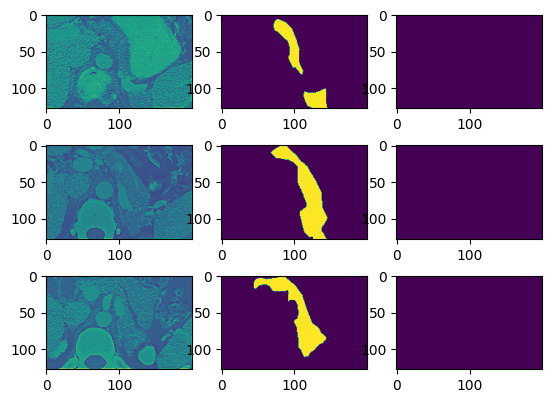

In [72]:
inputs=Variable(X_train[0]).type(dtype)
yhat = model(inputs.unsqueeze(0))
print_image(X_train[0],y_train[0],((yhat>0.5)).cpu().detach().numpy()[0],[40,50,60])

<Figure size 640x480 with 0 Axes>

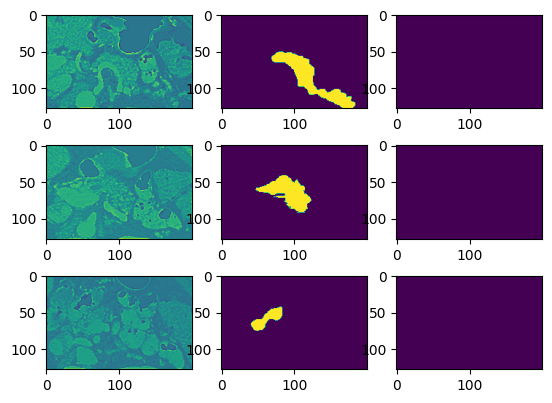

In [73]:
inputs=Variable(X_train[4]).type(dtype)
yhat = model(inputs.unsqueeze(0))
print_image(X_train[4],y_train[4],((yhat>0.5)).cpu().detach().numpy()[0],[40,50,60])

<Figure size 640x480 with 0 Axes>

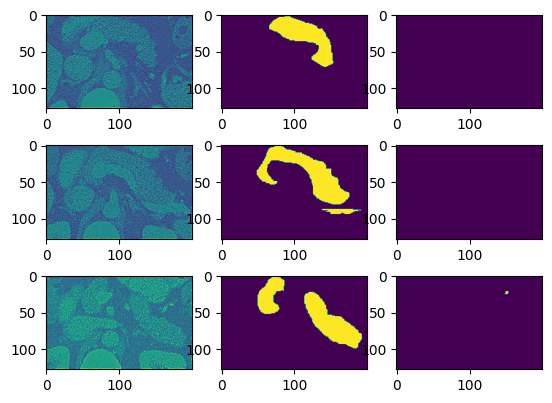

In [74]:
inputs=Variable(X_test[1]).type(dtype)
yhat = model(inputs.unsqueeze(0))
print_image(X_test[1],y_test[1],((yhat>0.5)).cpu().detach().numpy()[0],[40,50,60])

<Figure size 640x480 with 0 Axes>

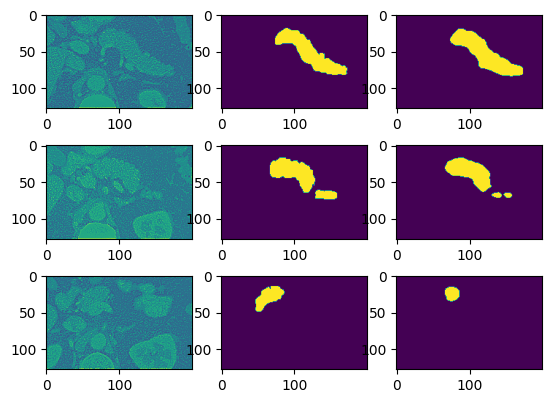

In [75]:
inputs=Variable(X_test[3]).type(dtype)
yhat = model(inputs.unsqueeze(0))
print_image(X_test[3],y_test[3],((yhat>0.5)).cpu().detach().numpy()[0],[40,50,60])

<Figure size 640x480 with 0 Axes>

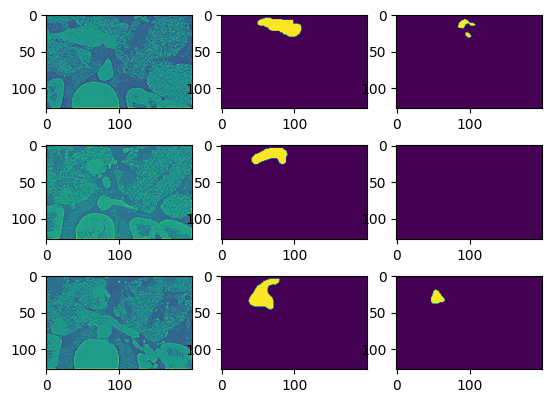

In [76]:
inputs=Variable(X_val[1]).type(dtype)
yhat = model(inputs.unsqueeze(0))
print_image(X_val[1],y_val[1],((yhat>0.5)).cpu().detach().numpy()[0],[40,50,60])

<Figure size 640x480 with 0 Axes>

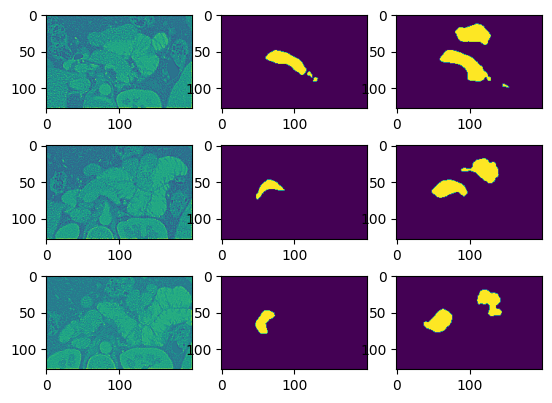

In [77]:
inputs=Variable(X_val[3]).type(dtype)
yhat = model(inputs.unsqueeze(0))
print_image(X_val[3],y_val[3],((yhat>0.5)).cpu().detach().numpy()[0],[40,50,60])

<Figure size 640x480 with 0 Axes>

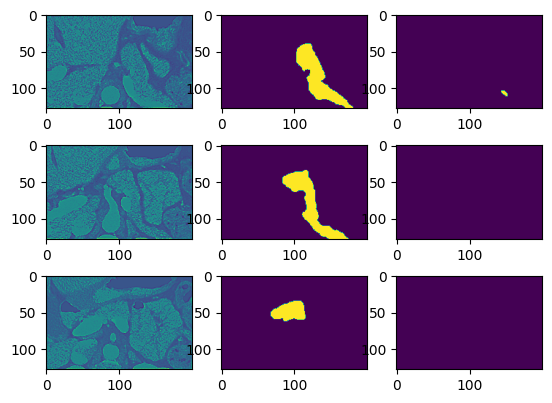

In [78]:
inputs=Variable(X_val[5]).type(dtype)
yhat = model(inputs.unsqueeze(0))
print_image(X_val[5],y_val[5],((yhat>0.5)).cpu().detach().numpy()[0],[40,50,60])